In [1]:

import os,sys
os.environ["CUDA_VISIBLE_DEVICES"]='1'
from rfdetr import RFDETRBase
from rfdetr.util.coco_classes import COCO_CLASSES
import supervision as sv
import numpy as np
from PIL import Image
#conda activate py311
import time
import torch

2025-07-17 02:32:26.249965: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-17 02:32:26.263627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752733946.277560 1556270 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752733946.281873 1556270 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752733946.294335 1556270 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:
checkpoint_path='/home/tangbw/works/pys/molrfdetr/mrf_output20250706/checkpoint0059.pth'#second trained
# 初始化模型
rf_model = RFDETRBase()

rf_model.model_config.pretrain_weights= checkpoint_path
rf_model.model = rf_model.get_model(rf_model.model_config)

# rfmol=rf_model.model.model.to('cpu')

rf-detr-base.pth: 100%|██████████| 355M/355M [00:14<00:00, 25.5MiB/s] 


Loading pretrain weights:@@@@@
rf-detr-base.pth
Loading pretrain weights:@@@@@
/home/tangbw/works/pys/molrfdetr/mrf_output20250706/checkpoint0059.pth


num_classes mismatch: pretrain weights has 23 classes, but your model has 90 classes
reinitializing detection head with 23 classes


In [5]:
import rfdetr
from rfdetr.deploy import export

In [7]:
device='cpu'
backbone_only=False
shape=[14*32,14*32]
batch_size=1
infer_dir='/home/tangbw/works/datas/view_check_acs/v3/acs_ac/ja064212t-Scheme-c1-1.png'
input_tensors = export.make_infer_image(infer_dir, shape, batch_size, device)
input_names = ['input']
output_names = ['features'] if backbone_only else ['dets', 'labels']
dynamic_axes = None


In [10]:
# Run model inference in pytorch mode
rfmol.eval()#.to("cuda")
# input_tensors = input_tensors.to("cuda")
with torch.no_grad():
    if backbone_only:
        features = rfmol(input_tensors)
        print(f"PyTorch inference output shape: {features.shape}")
    else:
        outputs = rfmol(input_tensors)
        dets = outputs['pred_boxes']
        labels = outputs['pred_logits']
        print(f"PyTorch inference output shapes - Boxes: {dets.shape}, Labels: {labels.shape}")


PyTorch inference output shapes - Boxes: torch.Size([1, 300, 4]), Labels: torch.Size([1, 300, 24])


In [15]:
#inference 
import supervision as sv
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image


In [2]:
checkpoint_path='/home/tangbw/works/pys/molrfdetr/mrf_output20250706/checkpoint0059.pth'#second trained
# 初始化模型
rf_model = RFDETRBase()
rf_model.model_config.pretrain_weights= checkpoint_path
rf_model.model = rf_model.get_model(rf_model.model_config)

# rfmol=rf_model.model.model.to('cpu')

Loading pretrain weights:@@@@@
rf-detr-base.pth
Loading pretrain weights:@@@@@
/home/tangbw/works/pys/molrfdetr/mrf_output20250706/checkpoint0059.pth


num_classes mismatch: pretrain weights has 23 classes, but your model has 90 classes
reinitializing detection head with 23 classes


In [3]:
data_dir="/home/tangbw/works/datas/view_check_R4/v3/R4_AUG/images"
ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{data_dir}/test",
    annotations_path=f"{data_dir}/test/_annotations.coco.json",
)

In [4]:
path, image, annotations = ds[0]
image = Image.open(path)


In [5]:
rf_model.optimize_for_inference()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


In [11]:
detections = rf_model.predict(image, threshold=0.6)

In [12]:
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)


In [13]:
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)


In [14]:
bbox_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    text_thickness=thickness,
    smart_position=True)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]


In [15]:
annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)


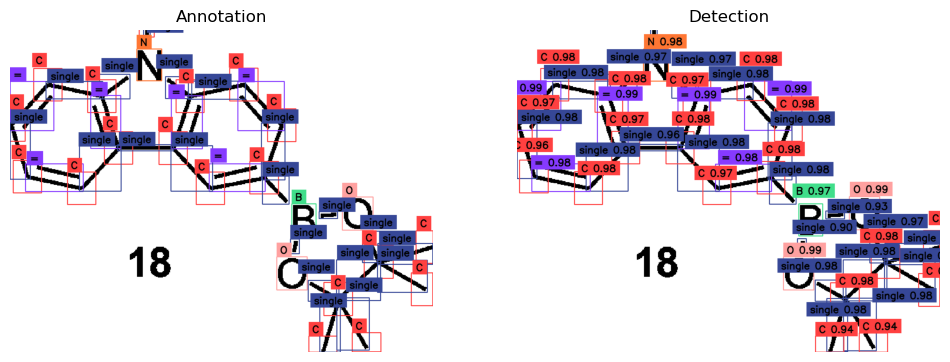

In [16]:
sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

In [20]:
## Evaluate fine-tuned model
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision


In [22]:

targets = []
predictions = []
debug=False
for path, image, annotations in tqdm(ds):
    image = Image.open(path)
     # 处理灰度或其他模式
    if image.mode == "L":
        if debug: print("检测到灰度图像 (1 通道)，转换为 RGB...")
        image = image.convert("RGB")
    elif image.mode != "RGB":
        if debug: print(f"检测到 {image.mode} 模式，转换为 RGB...")
        image = image.convert("RGB")

    detections = rf_model.predict(image, threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)

  3%|▎         | 333/12780 [00:20<11:06, 18.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 337/12780 [00:21<11:13, 18.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 341/12780 [00:21<11:42, 17.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 346/12780 [00:21<11:05, 18.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 350/12780 [00:21<10:59, 18.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 353/12780 [00:21<10:35, 19.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 357/12780 [00:22<10:45, 19.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 363/12780 [00:22<10:21, 19.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 365/12780 [00:22<11:36, 17.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 369/12780 [00:22<13:40, 15.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 371/12780 [00:23<13:42, 15.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 375/12780 [00:23<15:32, 13.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 380/12780 [00:23<12:34, 16.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 384/12780 [00:23<11:44, 17.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 388/12780 [00:24<11:54, 17.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 392/12780 [00:24<11:44, 17.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 394/12780 [00:24<14:25, 14.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 398/12780 [00:24<16:08, 12.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 402/12780 [00:25<13:56, 14.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 406/12780 [00:25<12:20, 16.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 409/12780 [00:25<10:55, 18.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 413/12780 [00:25<12:17, 16.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 415/12780 [00:25<12:11, 16.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 419/12780 [00:26<14:19, 14.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 421/12780 [00:26<14:58, 13.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 425/12780 [00:26<14:36, 14.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 429/12780 [00:26<15:00, 13.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 431/12780 [00:26<15:18, 13.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 435/12780 [00:27<14:30, 14.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 439/12780 [00:27<13:45, 14.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 443/12780 [00:27<12:43, 16.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  3%|▎         | 447/12780 [00:27<12:05, 16.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▎         | 451/12780 [00:28<11:56, 17.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▎         | 455/12780 [00:28<12:25, 16.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▎         | 459/12780 [00:28<11:45, 17.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▎         | 464/12780 [00:28<11:10, 18.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▎         | 469/12780 [00:29<10:50, 18.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▎         | 471/12780 [00:29<12:19, 16.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▎         | 475/12780 [00:29<14:47, 13.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▎         | 477/12780 [00:29<16:00, 12.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▎         | 479/12780 [00:30<17:35, 11.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 483/12780 [00:30<16:46, 12.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 487/12780 [00:30<15:10, 13.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 491/12780 [00:30<13:17, 15.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 495/12780 [00:31<12:00, 17.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 499/12780 [00:31<11:29, 17.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 503/12780 [00:31<11:04, 18.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 507/12780 [00:31<11:54, 17.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 509/12780 [00:31<12:35, 16.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 513/12780 [00:32<13:46, 14.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 517/12780 [00:32<13:17, 15.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 519/12780 [00:32<14:59, 13.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 523/12780 [00:32<16:13, 12.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 525/12780 [00:33<16:11, 12.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 529/12780 [00:33<15:57, 12.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 533/12780 [00:33<14:49, 13.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 537/12780 [00:33<13:18, 15.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 542/12780 [00:34<11:16, 18.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 546/12780 [00:34<11:16, 18.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 549/12780 [00:34<10:53, 18.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 553/12780 [00:34<11:34, 17.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 557/12780 [00:35<11:42, 17.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 562/12780 [00:35<11:03, 18.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 567/12780 [00:35<10:46, 18.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 571/12780 [00:35<11:43, 17.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  4%|▍         | 575/12780 [00:36<12:30, 16.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 577/12780 [00:36<14:53, 13.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 579/12780 [00:36<17:19, 11.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 581/12780 [00:36<18:47, 10.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 583/12780 [00:36<20:02, 10.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 587/12780 [00:37<16:31, 12.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 591/12780 [00:37<14:01, 14.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 595/12780 [00:37<12:46, 15.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 599/12780 [00:37<12:46, 15.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 603/12780 [00:38<12:39, 16.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 607/12780 [00:38<12:00, 16.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 611/12780 [00:38<11:30, 17.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 615/12780 [00:38<11:43, 17.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 619/12780 [00:39<12:23, 16.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 621/12780 [00:39<12:58, 15.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 623/12780 [00:39<14:05, 14.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 625/12780 [00:39<16:58, 11.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 627/12780 [00:39<19:03, 10.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 629/12780 [00:40<20:51,  9.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 633/12780 [00:40<20:44,  9.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▍         | 635/12780 [00:40<19:52, 10.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 639/12780 [00:41<19:48, 10.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 641/12780 [00:41<19:41, 10.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 645/12780 [00:41<15:52, 12.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 650/12780 [00:41<12:58, 15.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 655/12780 [00:42<12:13, 16.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 659/12780 [00:42<12:00, 16.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 662/12780 [00:42<11:08, 18.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 666/12780 [00:42<11:56, 16.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 670/12780 [00:42<12:38, 15.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 674/12780 [00:43<14:46, 13.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 676/12780 [00:43<16:00, 12.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 680/12780 [00:43<16:34, 12.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 684/12780 [00:44<13:45, 14.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 687/12780 [00:44<12:23, 16.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 691/12780 [00:44<12:27, 16.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 695/12780 [00:44<12:05, 16.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  5%|▌         | 699/12780 [00:44<12:28, 16.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 703/12780 [00:45<12:37, 15.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 707/12780 [00:45<12:31, 16.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 711/12780 [00:45<12:46, 15.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 715/12780 [00:45<11:39, 17.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 719/12780 [00:46<12:46, 15.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 723/12780 [00:46<12:56, 15.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 725/12780 [00:46<13:13, 15.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 729/12780 [00:46<14:54, 13.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 731/12780 [00:47<15:42, 12.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 735/12780 [00:47<16:06, 12.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 739/12780 [00:47<14:00, 14.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 741/12780 [00:47<14:43, 13.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 746/12780 [00:48<12:02, 16.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 751/12780 [00:48<11:07, 18.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 755/12780 [00:48<11:01, 18.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 759/12780 [00:48<10:53, 18.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 763/12780 [00:48<10:41, 18.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 767/12780 [00:49<10:57, 18.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 769/12780 [00:49<10:58, 18.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 773/12780 [00:49<14:09, 14.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 775/12780 [00:49<16:28, 12.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 777/12780 [00:50<17:10, 11.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 779/12780 [00:50<19:12, 10.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 781/12780 [00:50<19:47, 10.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 783/12780 [00:50<19:35, 10.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 787/12780 [00:50<16:46, 11.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 791/12780 [00:51<14:07, 14.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▌         | 795/12780 [00:51<12:29, 15.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▋         | 799/12780 [00:51<11:53, 16.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▋         | 803/12780 [00:51<12:11, 16.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▋         | 807/12780 [00:52<11:27, 17.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▋         | 811/12780 [00:52<11:11, 17.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▋         | 816/12780 [00:52<10:35, 18.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▋         | 821/12780 [00:52<10:05, 19.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▋         | 825/12780 [00:53<11:43, 17.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▋         | 827/12780 [00:53<12:40, 15.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  6%|▋         | 829/12780 [00:53<13:35, 14.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 833/12780 [00:53<15:31, 12.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 835/12780 [00:53<16:30, 12.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 839/12780 [00:54<14:59, 13.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 843/12780 [00:54<13:50, 14.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 846/12780 [00:54<12:26, 15.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 850/12780 [00:54<11:37, 17.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 854/12780 [00:55<11:23, 17.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 858/12780 [00:55<11:08, 17.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 862/12780 [00:55<10:48, 18.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 866/12780 [00:55<10:53, 18.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 870/12780 [00:56<11:28, 17.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 874/12780 [00:56<12:39, 15.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 876/12780 [00:56<14:50, 13.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 880/12780 [00:56<15:22, 12.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 882/12780 [00:56<15:18, 12.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 886/12780 [00:57<16:32, 11.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 888/12780 [00:57<16:45, 11.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 893/12780 [00:57<13:03, 15.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 897/12780 [00:57<12:29, 15.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 901/12780 [00:58<12:07, 16.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 905/12780 [00:58<11:47, 16.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 909/12780 [00:58<11:26, 17.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 913/12780 [00:58<11:37, 17.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 915/12780 [00:59<11:30, 17.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 920/12780 [00:59<11:38, 16.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 924/12780 [00:59<12:44, 15.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 926/12780 [00:59<14:01, 14.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 930/12780 [01:00<14:38, 13.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 932/12780 [01:00<15:44, 12.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 936/12780 [01:00<16:07, 12.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 940/12780 [01:00<13:42, 14.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 944/12780 [01:01<12:53, 15.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 948/12780 [01:01<12:44, 15.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 950/12780 [01:01<13:00, 15.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 954/12780 [01:01<12:45, 15.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  7%|▋         | 958/12780 [01:02<13:18, 14.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 960/12780 [01:02<13:51, 14.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 964/12780 [01:02<14:11, 13.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 968/12780 [01:02<13:32, 14.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 970/12780 [01:02<13:57, 14.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 974/12780 [01:03<14:11, 13.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 976/12780 [01:03<14:47, 13.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 980/12780 [01:03<14:26, 13.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 984/12780 [01:03<12:58, 15.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 988/12780 [01:04<11:54, 16.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 990/12780 [01:04<11:17, 17.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 995/12780 [01:04<10:53, 18.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 999/12780 [01:04<10:34, 18.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1003/12780 [01:04<10:50, 18.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1007/12780 [01:05<10:40, 18.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1011/12780 [01:05<11:39, 16.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1015/12780 [01:05<11:16, 17.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1019/12780 [01:05<10:41, 18.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1024/12780 [01:06<09:48, 19.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1029/12780 [01:06<10:22, 18.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1031/12780 [01:06<10:31, 18.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1036/12780 [01:06<11:07, 17.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1040/12780 [01:06<11:52, 16.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1044/12780 [01:07<11:47, 16.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1048/12780 [01:07<11:09, 17.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1052/12780 [01:07<11:00, 17.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1056/12780 [01:07<10:53, 17.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1060/12780 [01:08<10:46, 18.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1064/12780 [01:08<10:48, 18.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1068/12780 [01:08<11:13, 17.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1072/12780 [01:08<12:03, 16.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1076/12780 [01:09<11:39, 16.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1080/12780 [01:09<11:17, 17.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  8%|▊         | 1084/12780 [01:09<11:20, 17.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▊         | 1088/12780 [01:09<14:28, 13.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▊         | 1090/12780 [01:10<14:47, 13.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▊         | 1092/12780 [01:10<15:12, 12.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▊         | 1096/12780 [01:10<17:34, 11.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▊         | 1100/12780 [01:10<14:43, 13.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▊         | 1104/12780 [01:11<13:19, 14.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▊         | 1108/12780 [01:11<12:27, 15.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▊         | 1112/12780 [01:11<12:36, 15.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▊         | 1116/12780 [01:11<11:39, 16.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1120/12780 [01:12<11:58, 16.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1124/12780 [01:12<11:57, 16.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1128/12780 [01:12<12:12, 15.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1130/12780 [01:12<13:40, 14.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1132/12780 [01:12<15:47, 12.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1136/12780 [01:13<15:54, 12.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1138/12780 [01:13<16:20, 11.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1140/12780 [01:13<15:57, 12.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1144/12780 [01:13<17:05, 11.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1146/12780 [01:14<17:38, 10.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1150/12780 [01:14<15:53, 12.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1155/12780 [01:14<12:38, 15.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1159/12780 [01:15<12:26, 15.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1163/12780 [01:15<11:23, 16.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1167/12780 [01:15<11:03, 17.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1171/12780 [01:15<10:59, 17.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1174/12780 [01:15<10:09, 19.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1178/12780 [01:16<11:37, 16.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1182/12780 [01:16<12:29, 15.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1184/12780 [01:16<12:22, 15.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1186/12780 [01:16<13:31, 14.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1190/12780 [01:16<14:41, 13.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1192/12780 [01:17<14:36, 13.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1196/12780 [01:17<14:21, 13.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1200/12780 [01:17<13:04, 14.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1204/12780 [01:17<11:57, 16.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1208/12780 [01:18<11:24, 16.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


  9%|▉         | 1212/12780 [01:18<10:52, 17.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1216/12780 [01:18<10:41, 18.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1220/12780 [01:18<11:31, 16.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1224/12780 [01:19<10:56, 17.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1228/12780 [01:19<11:11, 17.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1230/12780 [01:19<12:33, 15.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1234/12780 [01:19<14:23, 13.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1236/12780 [01:19<14:36, 13.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1240/12780 [01:20<14:57, 12.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1242/12780 [01:20<14:41, 13.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1246/12780 [01:20<14:07, 13.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1250/12780 [01:20<12:53, 14.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1254/12780 [01:21<12:02, 15.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1258/12780 [01:21<11:18, 16.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1262/12780 [01:21<11:56, 16.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1266/12780 [01:21<11:19, 16.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1270/12780 [01:22<10:46, 17.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|▉         | 1274/12780 [01:22<11:15, 17.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1279/12780 [01:22<10:21, 18.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1281/12780 [01:22<12:10, 15.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1285/12780 [01:23<13:45, 13.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1287/12780 [01:23<14:02, 13.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1291/12780 [01:23<14:55, 12.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1293/12780 [01:23<15:07, 12.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1297/12780 [01:24<16:33, 11.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1299/12780 [01:24<16:54, 11.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1304/12780 [01:24<14:18, 13.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1309/12780 [01:24<11:42, 16.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1314/12780 [01:25<10:48, 17.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1318/12780 [01:25<11:35, 16.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1320/12780 [01:25<11:07, 17.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1325/12780 [01:25<10:22, 18.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1329/12780 [01:26<11:10, 17.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1331/12780 [01:26<13:11, 14.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1335/12780 [01:26<12:56, 14.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1337/12780 [01:26<13:58, 13.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1339/12780 [01:26<15:18, 12.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 10%|█         | 1341/12780 [01:27<16:48, 11.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1345/12780 [01:27<18:50, 10.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1347/12780 [01:27<17:07, 11.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1351/12780 [01:27<14:47, 12.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1355/12780 [01:28<12:26, 15.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1359/12780 [01:28<12:15, 15.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1363/12780 [01:28<11:36, 16.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1367/12780 [01:28<11:30, 16.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1371/12780 [01:29<10:53, 17.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1376/12780 [01:29<10:28, 18.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1378/12780 [01:29<12:12, 15.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1382/12780 [01:29<13:07, 14.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1384/12780 [01:29<14:05, 13.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1388/12780 [01:30<13:00, 14.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1392/12780 [01:30<13:07, 14.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1394/12780 [01:30<14:08, 13.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1398/12780 [01:30<12:52, 14.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1402/12780 [01:31<12:17, 15.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1406/12780 [01:31<11:39, 16.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1410/12780 [01:31<11:35, 16.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1414/12780 [01:31<11:00, 17.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1418/12780 [01:32<10:32, 17.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1422/12780 [01:32<10:33, 17.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1426/12780 [01:32<10:19, 18.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1430/12780 [01:32<10:27, 18.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1434/12780 [01:33<12:36, 14.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█         | 1436/12780 [01:33<13:06, 14.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█▏        | 1438/12780 [01:33<13:43, 13.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█▏        | 1440/12780 [01:33<16:15, 11.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█▏        | 1444/12780 [01:34<17:33, 10.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█▏        | 1448/12780 [01:34<14:22, 13.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█▏        | 1452/12780 [01:34<12:59, 14.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█▏        | 1456/12780 [01:34<11:50, 15.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█▏        | 1460/12780 [01:34<11:43, 16.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█▏        | 1462/12780 [01:35<11:54, 15.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 11%|█▏        | 1467/12780 [01:35<12:38, 14.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1471/12780 [01:35<11:42, 16.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1475/12780 [01:35<11:25, 16.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1479/12780 [01:36<11:21, 16.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1481/12780 [01:36<11:34, 16.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1485/12780 [01:36<13:43, 13.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1487/12780 [01:36<13:40, 13.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1491/12780 [01:37<14:00, 13.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1493/12780 [01:37<14:23, 13.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1497/12780 [01:37<13:59, 13.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1501/12780 [01:37<11:44, 16.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1506/12780 [01:37<10:45, 17.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1510/12780 [01:38<11:07, 16.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1514/12780 [01:38<10:53, 17.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1518/12780 [01:38<10:33, 17.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1522/12780 [01:38<10:26, 17.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1526/12780 [01:39<10:43, 17.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1530/12780 [01:39<11:06, 16.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1534/12780 [01:39<11:34, 16.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1538/12780 [01:39<11:24, 16.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1540/12780 [01:40<12:22, 15.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1544/12780 [01:40<12:21, 15.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1548/12780 [01:40<13:22, 14.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1550/12780 [01:40<13:46, 13.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1554/12780 [01:41<15:06, 12.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1558/12780 [01:41<12:57, 14.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1562/12780 [01:41<11:40, 16.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1566/12780 [01:41<11:09, 16.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1570/12780 [01:42<10:54, 17.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1574/12780 [01:42<11:28, 16.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1578/12780 [01:42<10:54, 17.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1582/12780 [01:42<11:05, 16.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1586/12780 [01:42<10:54, 17.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1590/12780 [01:43<12:01, 15.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1592/12780 [01:43<12:42, 14.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 12%|█▏        | 1596/12780 [01:43<13:32, 13.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1598/12780 [01:43<13:44, 13.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1602/12780 [01:44<14:29, 12.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1604/12780 [01:44<14:44, 12.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1608/12780 [01:44<13:41, 13.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1612/12780 [01:44<12:01, 15.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1616/12780 [01:45<11:09, 16.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1620/12780 [01:45<10:38, 17.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1624/12780 [01:45<10:27, 17.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1628/12780 [01:45<10:28, 17.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1632/12780 [01:45<10:16, 18.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1636/12780 [01:46<10:47, 17.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1640/12780 [01:46<11:03, 16.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1644/12780 [01:46<11:42, 15.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1646/12780 [01:46<12:32, 14.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1650/12780 [01:47<15:47, 11.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1652/12780 [01:47<16:42, 11.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1654/12780 [01:47<18:05, 10.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1656/12780 [01:47<18:24, 10.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1661/12780 [01:48<13:52, 13.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1665/12780 [01:48<12:09, 15.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1669/12780 [01:48<11:36, 15.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1673/12780 [01:48<11:52, 15.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1677/12780 [01:49<11:09, 16.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1681/12780 [01:49<11:48, 15.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1685/12780 [01:49<11:44, 15.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1687/12780 [01:49<12:12, 15.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1691/12780 [01:50<12:44, 14.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1693/12780 [01:50<14:13, 12.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1697/12780 [01:50<15:15, 12.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1699/12780 [01:50<16:57, 10.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1701/12780 [01:51<17:50, 10.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1705/12780 [01:51<14:35, 12.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1709/12780 [01:51<12:56, 14.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1713/12780 [01:51<12:09, 15.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1717/12780 [01:52<13:20, 13.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1719/12780 [01:52<14:22, 12.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 13%|█▎        | 1723/12780 [01:52<13:08, 14.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▎        | 1728/12780 [01:52<10:41, 17.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▎        | 1733/12780 [01:53<10:30, 17.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▎        | 1737/12780 [01:53<11:07, 16.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▎        | 1739/12780 [01:53<11:57, 15.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▎        | 1743/12780 [01:53<13:13, 13.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▎        | 1745/12780 [01:53<14:03, 13.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▎        | 1749/12780 [01:54<13:52, 13.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▎        | 1753/12780 [01:54<11:48, 15.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1758/12780 [01:54<10:37, 17.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1762/12780 [01:55<10:29, 17.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1765/12780 [01:55<09:54, 18.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1769/12780 [01:55<10:00, 18.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1773/12780 [01:55<09:56, 18.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1777/12780 [01:55<09:48, 18.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1781/12780 [01:56<11:33, 15.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1784/12780 [01:56<10:36, 17.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1788/12780 [01:56<13:12, 13.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1790/12780 [01:56<13:59, 13.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1794/12780 [01:57<14:23, 12.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1798/12780 [01:57<13:17, 13.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1800/12780 [01:57<13:38, 13.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1805/12780 [01:57<10:49, 16.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1810/12780 [01:57<09:27, 19.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1815/12780 [01:58<08:35, 21.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1818/12780 [01:58<08:40, 21.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1825/12780 [01:58<07:06, 25.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1828/12780 [01:58<08:22, 21.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1834/12780 [01:59<09:34, 19.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1838/12780 [01:59<10:07, 18.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1841/12780 [01:59<09:46, 18.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1845/12780 [01:59<10:22, 17.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1849/12780 [02:00<11:50, 15.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 14%|█▍        | 1851/12780 [02:00<12:29, 14.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1855/12780 [02:00<14:20, 12.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1857/12780 [02:00<13:57, 13.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1862/12780 [02:01<11:55, 15.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1866/12780 [02:01<11:20, 16.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1870/12780 [02:01<10:48, 16.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1874/12780 [02:01<11:13, 16.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1878/12780 [02:01<11:05, 16.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1882/12780 [02:02<10:37, 17.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1886/12780 [02:02<10:31, 17.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1889/12780 [02:02<09:34, 18.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1894/12780 [02:02<10:24, 17.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1898/12780 [02:03<11:03, 16.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1900/12780 [02:03<11:51, 15.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1902/12780 [02:03<12:29, 14.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1904/12780 [02:03<14:26, 12.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1906/12780 [02:03<15:56, 11.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1910/12780 [02:04<15:59, 11.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1912/12780 [02:04<15:49, 11.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▍        | 1916/12780 [02:04<13:17, 13.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▌        | 1920/12780 [02:04<11:51, 15.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▌        | 1924/12780 [02:05<12:39, 14.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▌        | 1926/12780 [02:05<12:11, 14.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▌        | 1931/12780 [02:05<11:06, 16.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▌        | 1936/12780 [02:05<09:43, 18.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▌        | 1941/12780 [02:06<09:02, 19.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▌        | 1945/12780 [02:06<10:21, 17.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▌        | 1947/12780 [02:06<11:14, 16.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▌        | 1951/12780 [02:06<13:45, 13.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▌        | 1955/12780 [02:07<12:28, 14.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▌        | 1960/12780 [02:07<10:36, 17.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▌        | 1962/12780 [02:07<11:12, 16.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▌        | 1966/12780 [02:07<11:03, 16.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▌        | 1970/12780 [02:07<11:13, 16.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▌        | 1975/12780 [02:08<10:08, 17.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 15%|█▌        | 1979/12780 [02:08<10:09, 17.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 1983/12780 [02:08<10:07, 17.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 1987/12780 [02:08<10:41, 16.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 1991/12780 [02:09<10:49, 16.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 1995/12780 [02:09<11:01, 16.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 1999/12780 [02:09<10:37, 16.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2002/12780 [02:09<10:19, 17.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2006/12780 [02:10<11:45, 15.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2008/12780 [02:10<12:01, 14.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2012/12780 [02:10<13:09, 13.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2014/12780 [02:10<13:42, 13.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2018/12780 [02:11<15:37, 11.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2022/12780 [02:11<13:50, 12.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2026/12780 [02:11<12:14, 14.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2030/12780 [02:11<11:32, 15.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2034/12780 [02:12<10:48, 16.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2038/12780 [02:12<11:04, 16.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2043/12780 [02:12<09:49, 18.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2047/12780 [02:12<10:37, 16.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2049/12780 [02:13<11:27, 15.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2053/12780 [02:13<12:49, 13.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2055/12780 [02:13<13:26, 13.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2059/12780 [02:13<14:14, 12.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2061/12780 [02:14<14:17, 12.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2065/12780 [02:14<15:30, 11.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2067/12780 [02:14<15:32, 11.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2071/12780 [02:14<12:26, 14.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▌        | 2075/12780 [02:15<11:21, 15.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▋        | 2079/12780 [02:15<10:38, 16.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▋        | 2083/12780 [02:15<10:16, 17.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▋        | 2087/12780 [02:15<09:56, 17.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▋        | 2091/12780 [02:15<09:39, 18.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▋        | 2095/12780 [02:16<09:54, 17.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▋        | 2099/12780 [02:16<10:26, 17.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▋        | 2101/12780 [02:16<11:13, 15.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▋        | 2105/12780 [02:16<13:22, 13.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 16%|█▋        | 2107/12780 [02:17<13:28, 13.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2111/12780 [02:17<12:53, 13.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2115/12780 [02:17<13:24, 13.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2119/12780 [02:17<11:31, 15.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2123/12780 [02:18<11:08, 15.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2127/12780 [02:18<11:19, 15.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2131/12780 [02:18<10:34, 16.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2135/12780 [02:18<11:01, 16.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2139/12780 [02:19<10:56, 16.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2143/12780 [02:19<11:02, 16.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2145/12780 [02:19<10:41, 16.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2149/12780 [02:19<11:38, 15.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2153/12780 [02:19<11:31, 15.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2155/12780 [02:20<11:40, 15.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2159/12780 [02:20<14:27, 12.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2161/12780 [02:20<14:25, 12.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2165/12780 [02:20<15:12, 11.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2169/12780 [02:21<12:29, 14.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2173/12780 [02:21<10:53, 16.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2177/12780 [02:21<11:00, 16.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2181/12780 [02:21<10:56, 16.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2185/12780 [02:22<10:48, 16.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2189/12780 [02:22<10:28, 16.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2193/12780 [02:22<10:03, 17.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2195/12780 [02:22<10:00, 17.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2200/12780 [02:22<09:35, 18.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2204/12780 [02:23<11:44, 15.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2208/12780 [02:23<11:28, 15.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2210/12780 [02:23<12:17, 14.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2214/12780 [02:24<12:46, 13.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2216/12780 [02:24<13:25, 13.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2220/12780 [02:24<12:46, 13.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2222/12780 [02:24<14:01, 12.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2226/12780 [02:24<11:55, 14.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2230/12780 [02:25<10:52, 16.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 17%|█▋        | 2234/12780 [02:25<10:11, 17.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2238/12780 [02:25<10:03, 17.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2242/12780 [02:25<09:47, 17.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2246/12780 [02:26<09:34, 18.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2250/12780 [02:26<09:31, 18.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2254/12780 [02:26<09:59, 17.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2258/12780 [02:26<12:11, 14.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2262/12780 [02:27<12:22, 14.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2264/12780 [02:27<12:00, 14.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2268/12780 [02:27<13:30, 12.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2272/12780 [02:27<12:42, 13.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2276/12780 [02:28<11:41, 14.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2280/12780 [02:28<10:35, 16.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2284/12780 [02:28<10:50, 16.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2288/12780 [02:28<10:14, 17.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2291/12780 [02:28<09:28, 18.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2296/12780 [02:29<09:00, 19.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2300/12780 [02:29<09:14, 18.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2305/12780 [02:29<08:45, 19.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2309/12780 [02:29<10:30, 16.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2311/12780 [02:30<11:20, 15.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2315/12780 [02:30<12:07, 14.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2317/12780 [02:30<12:25, 14.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2321/12780 [02:30<12:54, 13.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2323/12780 [02:30<12:25, 14.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2329/12780 [02:31<09:42, 17.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2333/12780 [02:31<10:19, 16.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2335/12780 [02:31<11:16, 15.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2339/12780 [02:31<12:36, 13.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2341/12780 [02:32<12:31, 13.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2345/12780 [02:32<12:32, 13.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2349/12780 [02:32<11:43, 14.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2353/12780 [02:32<11:07, 15.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2358/12780 [02:33<09:38, 18.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 18%|█▊        | 2364/12780 [02:33<08:17, 20.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▊        | 2367/12780 [02:33<08:00, 21.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▊        | 2373/12780 [02:33<08:00, 21.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▊        | 2379/12780 [02:34<07:53, 21.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▊        | 2382/12780 [02:34<07:50, 22.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▊        | 2388/12780 [02:34<07:40, 22.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▊        | 2394/12780 [02:34<07:39, 22.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2397/12780 [02:34<07:38, 22.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2403/12780 [02:35<07:35, 22.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2409/12780 [02:35<07:34, 22.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2412/12780 [02:35<07:33, 22.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2418/12780 [02:35<07:31, 22.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2424/12780 [02:35<07:33, 22.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2427/12780 [02:36<07:35, 22.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2433/12780 [02:36<07:28, 23.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2439/12780 [02:36<07:13, 23.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2445/12780 [02:36<06:59, 24.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2452/12780 [02:37<06:02, 28.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2458/12780 [02:37<06:02, 28.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2464/12780 [02:37<06:13, 27.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2470/12780 [02:37<06:07, 28.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2477/12780 [02:37<05:53, 29.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2483/12780 [02:38<06:23, 26.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2486/12780 [02:38<06:49, 25.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 19%|█▉        | 2492/12780 [02:38<06:43, 25.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|█▉        | 2498/12780 [02:38<06:46, 25.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|█▉        | 2504/12780 [02:39<06:39, 25.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|█▉        | 2510/12780 [02:39<06:58, 24.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|█▉        | 2516/12780 [02:39<06:46, 25.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|█▉        | 2519/12780 [02:39<06:43, 25.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|█▉        | 2525/12780 [02:39<07:08, 23.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|█▉        | 2531/12780 [02:40<07:03, 24.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|█▉        | 2537/12780 [02:40<06:44, 25.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|█▉        | 2543/12780 [02:40<06:41, 25.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|█▉        | 2546/12780 [02:40<07:09, 23.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|█▉        | 2552/12780 [02:41<07:18, 23.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|█▉        | 2555/12780 [02:41<07:06, 23.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2561/12780 [02:41<07:13, 23.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2564/12780 [02:41<07:54, 21.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2569/12780 [02:41<09:54, 17.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2571/12780 [02:42<11:01, 15.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2575/12780 [02:42<12:39, 13.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2577/12780 [02:42<13:04, 13.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2581/12780 [02:42<13:53, 12.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2583/12780 [02:43<13:51, 12.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2587/12780 [02:43<13:33, 12.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2591/12780 [02:43<11:48, 14.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2595/12780 [02:43<11:49, 14.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2599/12780 [02:44<11:12, 15.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2603/12780 [02:44<10:13, 16.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2607/12780 [02:44<10:03, 16.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2611/12780 [02:44<09:47, 17.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2615/12780 [02:45<09:29, 17.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 20%|██        | 2619/12780 [02:45<09:27, 17.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2621/12780 [02:45<10:41, 15.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2625/12780 [02:45<11:04, 15.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2629/12780 [02:46<11:23, 14.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2631/12780 [02:46<11:47, 14.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2635/12780 [02:46<12:28, 13.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2639/12780 [02:46<11:23, 14.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2643/12780 [02:46<10:33, 15.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2645/12780 [02:47<10:21, 16.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2649/12780 [02:47<10:51, 15.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2653/12780 [02:47<10:37, 15.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2657/12780 [02:47<10:47, 15.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2661/12780 [02:48<10:28, 16.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2665/12780 [02:48<09:35, 17.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2669/12780 [02:48<09:21, 18.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2673/12780 [02:48<10:46, 15.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2675/12780 [02:48<11:21, 14.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2679/12780 [02:49<11:51, 14.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2681/12780 [02:49<12:48, 13.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2683/12780 [02:49<14:43, 11.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2687/12780 [02:49<14:05, 11.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2691/12780 [02:50<11:37, 14.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2695/12780 [02:50<10:30, 16.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2699/12780 [02:50<10:34, 15.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2703/12780 [02:50<09:57, 16.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2707/12780 [02:51<09:41, 17.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2711/12780 [02:51<09:27, 17.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██        | 2715/12780 [02:51<09:21, 17.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██▏       | 2719/12780 [02:51<09:23, 17.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██▏       | 2723/12780 [02:52<09:13, 18.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██▏       | 2727/12780 [02:52<10:11, 16.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██▏       | 2729/12780 [02:52<10:59, 15.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██▏       | 2733/12780 [02:52<12:58, 12.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██▏       | 2735/12780 [02:52<13:07, 12.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██▏       | 2739/12780 [02:53<12:40, 13.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 21%|██▏       | 2744/12780 [02:53<10:37, 15.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2748/12780 [02:53<10:57, 15.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2752/12780 [02:54<10:27, 15.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2756/12780 [02:54<10:15, 16.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2758/12780 [02:54<10:17, 16.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2762/12780 [02:54<12:59, 12.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2764/12780 [02:54<12:38, 13.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2768/12780 [02:55<12:07, 13.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2772/12780 [02:55<13:00, 12.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2774/12780 [02:55<13:02, 12.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2778/12780 [02:56<14:11, 11.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2780/12780 [02:56<14:23, 11.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2784/12780 [02:56<12:57, 12.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2788/12780 [02:56<13:27, 12.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2790/12780 [02:57<14:07, 11.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2794/12780 [02:57<12:14, 13.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2798/12780 [02:57<10:55, 15.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2802/12780 [02:57<10:33, 15.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2806/12780 [02:58<10:50, 15.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2810/12780 [02:58<11:17, 14.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2812/12780 [02:58<12:56, 12.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2816/12780 [02:58<13:14, 12.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2818/12780 [02:59<14:04, 11.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2822/12780 [02:59<13:39, 12.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2826/12780 [02:59<11:47, 14.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2830/12780 [02:59<10:28, 15.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2834/12780 [03:00<10:05, 16.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2838/12780 [03:00<10:26, 15.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2842/12780 [03:00<10:20, 16.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2844/12780 [03:00<10:48, 15.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2848/12780 [03:01<11:45, 14.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2850/12780 [03:01<11:31, 14.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2855/12780 [03:01<11:07, 14.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2857/12780 [03:01<11:32, 14.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2861/12780 [03:01<11:33, 14.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2865/12780 [03:02<12:07, 13.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2867/12780 [03:02<12:06, 13.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2869/12780 [03:02<13:08, 12.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 22%|██▏       | 2873/12780 [03:02<14:05, 11.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2877/12780 [03:03<11:37, 14.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2881/12780 [03:03<10:02, 16.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2885/12780 [03:03<09:35, 17.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2889/12780 [03:03<09:17, 17.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2893/12780 [03:04<10:20, 15.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2895/12780 [03:04<11:18, 14.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2899/12780 [03:04<13:13, 12.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2901/12780 [03:04<13:18, 12.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2905/12780 [03:05<15:08, 10.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2907/12780 [03:05<15:47, 10.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2911/12780 [03:05<16:00, 10.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2913/12780 [03:05<15:26, 10.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2917/12780 [03:06<14:00, 11.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2919/12780 [03:06<14:14, 11.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2923/12780 [03:06<14:31, 11.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2925/12780 [03:06<14:18, 11.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2929/12780 [03:07<11:49, 13.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2933/12780 [03:07<10:09, 16.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2938/12780 [03:07<09:37, 17.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2942/12780 [03:07<09:26, 17.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2946/12780 [03:08<09:13, 17.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2950/12780 [03:08<09:34, 17.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2954/12780 [03:08<10:05, 16.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2956/12780 [03:08<10:43, 15.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2960/12780 [03:09<12:38, 12.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2962/12780 [03:09<13:02, 12.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2966/12780 [03:09<13:48, 11.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2970/12780 [03:09<12:02, 13.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2974/12780 [03:10<11:05, 14.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2978/12780 [03:10<10:33, 15.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2982/12780 [03:10<09:44, 16.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2984/12780 [03:10<10:19, 15.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2988/12780 [03:11<11:19, 14.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2992/12780 [03:11<10:27, 15.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2996/12780 [03:11<11:02, 14.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 2998/12780 [03:11<10:59, 14.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 23%|██▎       | 3002/12780 [03:12<11:31, 14.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▎       | 3004/12780 [03:12<11:49, 13.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▎       | 3006/12780 [03:12<13:28, 12.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▎       | 3010/12780 [03:12<13:38, 11.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▎       | 3014/12780 [03:13<12:36, 12.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▎       | 3018/12780 [03:13<10:50, 15.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▎       | 3020/12780 [03:13<11:24, 14.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▎       | 3024/12780 [03:13<11:21, 14.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▎       | 3028/12780 [03:13<11:00, 14.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▎       | 3032/12780 [03:14<10:31, 15.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3036/12780 [03:14<10:26, 15.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3040/12780 [03:14<09:49, 16.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3044/12780 [03:14<09:41, 16.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3048/12780 [03:15<09:06, 17.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3052/12780 [03:15<09:45, 16.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3056/12780 [03:15<09:47, 16.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3058/12780 [03:15<09:45, 16.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3062/12780 [03:16<11:32, 14.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3066/12780 [03:16<10:36, 15.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3070/12780 [03:16<10:27, 15.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3074/12780 [03:16<10:55, 14.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3078/12780 [03:17<10:15, 15.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3080/12780 [03:17<09:50, 16.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3084/12780 [03:17<11:00, 14.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3086/12780 [03:17<10:55, 14.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3090/12780 [03:17<10:47, 14.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3095/12780 [03:18<09:46, 16.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3097/12780 [03:18<10:38, 15.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3101/12780 [03:18<12:23, 13.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3103/12780 [03:18<13:00, 12.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3107/12780 [03:19<13:34, 11.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3109/12780 [03:19<12:59, 12.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3113/12780 [03:19<12:29, 12.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3117/12780 [03:19<10:47, 14.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3121/12780 [03:20<10:22, 15.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3125/12780 [03:20<10:12, 15.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 24%|██▍       | 3129/12780 [03:20<09:21, 17.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3133/12780 [03:20<09:38, 16.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3137/12780 [03:21<09:21, 17.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3142/12780 [03:21<09:35, 16.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3147/12780 [03:21<08:50, 18.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3149/12780 [03:21<10:19, 15.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3153/12780 [03:22<11:53, 13.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3155/12780 [03:22<13:37, 11.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3157/12780 [03:22<13:50, 11.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3161/12780 [03:22<13:44, 11.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3166/12780 [03:23<10:24, 15.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3170/12780 [03:23<09:55, 16.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3174/12780 [03:23<09:16, 17.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3178/12780 [03:23<09:02, 17.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3182/12780 [03:24<09:11, 17.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3186/12780 [03:24<09:18, 17.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3190/12780 [03:24<09:00, 17.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▍       | 3194/12780 [03:24<08:52, 17.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3198/12780 [03:25<10:20, 15.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3200/12780 [03:25<11:07, 14.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3204/12780 [03:25<12:05, 13.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3206/12780 [03:25<12:38, 12.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3210/12780 [03:26<13:42, 11.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3212/12780 [03:26<14:35, 10.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3216/12780 [03:26<12:34, 12.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3220/12780 [03:26<10:45, 14.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3224/12780 [03:27<10:09, 15.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3228/12780 [03:27<09:34, 16.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3232/12780 [03:27<09:06, 17.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3236/12780 [03:27<08:57, 17.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3240/12780 [03:27<09:39, 16.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3244/12780 [03:28<09:28, 16.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3249/12780 [03:28<10:53, 14.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3251/12780 [03:28<12:20, 12.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 25%|██▌       | 3255/12780 [03:29<13:05, 12.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3259/12780 [03:29<11:26, 13.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3263/12780 [03:29<10:46, 14.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3267/12780 [03:29<10:25, 15.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3271/12780 [03:30<09:33, 16.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3275/12780 [03:30<09:45, 16.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3279/12780 [03:30<09:11, 17.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3283/12780 [03:30<09:30, 16.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3287/12780 [03:31<09:08, 17.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3291/12780 [03:31<09:40, 16.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3295/12780 [03:31<09:05, 17.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3297/12780 [03:31<09:05, 17.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3301/12780 [03:31<11:21, 13.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3303/12780 [03:32<11:39, 13.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3307/12780 [03:32<12:39, 12.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3309/12780 [03:32<13:30, 11.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3313/12780 [03:32<12:28, 12.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3317/12780 [03:33<11:23, 13.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3321/12780 [03:33<10:35, 14.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3325/12780 [03:33<09:28, 16.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3329/12780 [03:33<09:49, 16.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3333/12780 [03:34<10:12, 15.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3337/12780 [03:34<10:15, 15.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3341/12780 [03:34<09:25, 16.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3345/12780 [03:35<11:14, 13.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3347/12780 [03:35<12:55, 12.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3349/12780 [03:35<14:39, 10.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▌       | 3351/12780 [03:35<14:44, 10.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▋       | 3355/12780 [03:35<13:53, 11.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▋       | 3357/12780 [03:36<13:34, 11.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▋       | 3361/12780 [03:36<14:03, 11.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▋       | 3363/12780 [03:36<14:09, 11.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▋       | 3367/12780 [03:36<12:26, 12.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▋       | 3372/12780 [03:37<10:02, 15.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▋       | 3375/12780 [03:37<09:13, 16.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▋       | 3379/12780 [03:37<09:01, 17.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 26%|██▋       | 3385/12780 [03:37<08:22, 18.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3388/12780 [03:38<07:42, 20.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3391/12780 [03:38<10:05, 15.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3393/12780 [03:38<10:45, 14.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3397/12780 [03:38<11:22, 13.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3399/12780 [03:38<11:31, 13.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3403/12780 [03:39<12:17, 12.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3407/12780 [03:39<10:47, 14.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3411/12780 [03:39<10:38, 14.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3415/12780 [03:40<09:37, 16.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3419/12780 [03:40<09:18, 16.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3423/12780 [03:40<09:13, 16.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3427/12780 [03:40<09:07, 17.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3431/12780 [03:40<09:37, 16.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3435/12780 [03:41<09:12, 16.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3439/12780 [03:41<09:13, 16.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3441/12780 [03:41<09:00, 17.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3446/12780 [03:41<10:07, 15.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3448/12780 [03:42<10:07, 15.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3452/12780 [03:42<10:54, 14.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3454/12780 [03:42<11:27, 13.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3458/12780 [03:42<11:47, 13.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3460/12780 [03:42<12:04, 12.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3464/12780 [03:43<13:08, 11.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3468/12780 [03:43<11:37, 13.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3472/12780 [03:43<10:21, 14.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3476/12780 [03:44<09:26, 16.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3480/12780 [03:44<09:08, 16.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3484/12780 [03:44<08:55, 17.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3488/12780 [03:44<08:35, 18.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3492/12780 [03:44<08:53, 17.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3494/12780 [03:45<09:57, 15.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3498/12780 [03:45<11:41, 13.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3500/12780 [03:45<11:54, 12.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3504/12780 [03:46<13:26, 11.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3506/12780 [03:46<13:47, 11.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3508/12780 [03:46<15:17, 10.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3510/12780 [03:46<15:34,  9.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 27%|██▋       | 3512/12780 [03:46<15:21, 10.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3516/12780 [03:47<12:58, 11.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3520/12780 [03:47<11:06, 13.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3524/12780 [03:47<10:28, 14.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3528/12780 [03:47<10:16, 15.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3532/12780 [03:48<11:24, 13.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3536/12780 [03:48<10:44, 14.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3540/12780 [03:48<10:02, 15.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3542/12780 [03:48<10:18, 14.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3546/12780 [03:49<11:27, 13.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3548/12780 [03:49<11:48, 13.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3552/12780 [03:49<12:21, 12.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3556/12780 [03:49<10:30, 14.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3560/12780 [03:50<09:31, 16.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3564/12780 [03:50<09:10, 16.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3566/12780 [03:50<09:08, 16.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3570/12780 [03:50<09:17, 16.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3574/12780 [03:50<09:16, 16.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3578/12780 [03:51<09:16, 16.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3582/12780 [03:51<08:50, 17.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3586/12780 [03:51<09:20, 16.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3590/12780 [03:51<09:50, 15.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3592/12780 [03:52<10:01, 15.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3596/12780 [03:52<10:50, 14.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3598/12780 [03:52<11:29, 13.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3602/12780 [03:52<12:36, 12.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3604/12780 [03:53<13:04, 11.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3608/12780 [03:53<10:44, 14.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3612/12780 [03:53<09:28, 16.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3616/12780 [03:53<09:02, 16.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3620/12780 [03:54<08:38, 17.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3624/12780 [03:54<08:37, 17.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3628/12780 [03:54<08:31, 17.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3632/12780 [03:54<08:49, 17.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3636/12780 [03:54<09:30, 16.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3640/12780 [03:55<10:33, 14.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 28%|██▊       | 3642/12780 [03:55<10:49, 14.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▊       | 3646/12780 [03:55<11:39, 13.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▊       | 3648/12780 [03:55<12:16, 12.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▊       | 3650/12780 [03:56<12:52, 11.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▊       | 3654/12780 [03:56<13:29, 11.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▊       | 3656/12780 [03:56<12:54, 11.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▊       | 3660/12780 [03:56<11:29, 13.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▊       | 3664/12780 [03:57<10:02, 15.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▊       | 3668/12780 [03:57<09:22, 16.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▊       | 3672/12780 [03:57<09:10, 16.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3676/12780 [03:57<09:04, 16.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3680/12780 [03:58<08:49, 17.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3684/12780 [03:58<08:36, 17.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3687/12780 [03:58<08:42, 17.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3691/12780 [03:58<09:47, 15.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3693/12780 [03:58<10:50, 13.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3695/12780 [03:59<11:30, 13.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3699/12780 [03:59<13:11, 11.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3701/12780 [03:59<12:12, 12.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3707/12780 [03:59<09:31, 15.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3711/12780 [04:00<09:36, 15.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3715/12780 [04:00<09:19, 16.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3718/12780 [04:00<08:44, 17.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3722/12780 [04:00<09:05, 16.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3726/12780 [04:01<08:45, 17.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3730/12780 [04:01<08:28, 17.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3734/12780 [04:01<10:27, 14.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3736/12780 [04:01<10:25, 14.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3740/12780 [04:02<11:27, 13.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3742/12780 [04:02<12:12, 12.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3746/12780 [04:02<11:36, 12.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3748/12780 [04:02<12:30, 12.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3752/12780 [04:03<11:10, 13.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3757/12780 [04:03<09:06, 16.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3761/12780 [04:03<08:36, 17.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3765/12780 [04:03<08:28, 17.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 29%|██▉       | 3769/12780 [04:03<08:36, 17.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3773/12780 [04:04<08:31, 17.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3776/12780 [04:04<08:20, 17.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3781/12780 [04:04<08:10, 18.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3783/12780 [04:04<08:58, 16.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3785/12780 [04:04<11:11, 13.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3787/12780 [04:05<12:42, 11.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3789/12780 [04:05<13:40, 10.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3791/12780 [04:05<13:49, 10.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3795/12780 [04:05<13:14, 11.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3797/12780 [04:06<13:03, 11.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3802/12780 [04:06<10:16, 14.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3807/12780 [04:06<09:08, 16.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3811/12780 [04:06<08:43, 17.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3816/12780 [04:07<08:12, 18.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3818/12780 [04:07<08:14, 18.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3823/12780 [04:07<07:20, 20.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3826/12780 [04:07<07:18, 20.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|██▉       | 3831/12780 [04:07<07:54, 18.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3834/12780 [04:08<07:47, 19.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3839/12780 [04:08<08:34, 17.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3843/12780 [04:08<09:12, 16.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3845/12780 [04:08<09:48, 15.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3849/12780 [04:09<10:47, 13.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3851/12780 [04:09<10:59, 13.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3855/12780 [04:09<11:32, 12.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3860/12780 [04:09<08:33, 17.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3864/12780 [04:10<08:25, 17.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3870/12780 [04:10<07:21, 20.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3875/12780 [04:10<07:45, 19.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3879/12780 [04:10<07:49, 18.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3883/12780 [04:11<08:40, 17.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3887/12780 [04:11<09:22, 15.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3891/12780 [04:11<09:15, 16.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3893/12780 [04:11<10:16, 14.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 30%|███       | 3897/12780 [04:12<11:08, 13.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3899/12780 [04:12<11:48, 12.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3903/12780 [04:12<11:40, 12.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3907/12780 [04:12<09:39, 15.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3910/12780 [04:12<09:33, 15.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3914/12780 [04:13<10:12, 14.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3919/12780 [04:13<08:45, 16.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3921/12780 [04:13<08:53, 16.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3925/12780 [04:13<08:54, 16.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3929/12780 [04:14<09:21, 15.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3933/12780 [04:14<08:52, 16.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3936/12780 [04:14<08:46, 16.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3938/12780 [04:14<10:02, 14.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3942/12780 [04:15<12:48, 11.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3944/12780 [04:15<13:37, 10.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3946/12780 [04:15<13:22, 11.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3950/12780 [04:15<12:04, 12.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3954/12780 [04:16<10:51, 13.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3958/12780 [04:16<09:21, 15.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3960/12780 [04:16<09:47, 15.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3964/12780 [04:16<09:58, 14.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3968/12780 [04:17<09:01, 16.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3972/12780 [04:17<08:50, 16.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3976/12780 [04:17<08:50, 16.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3980/12780 [04:17<08:49, 16.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3985/12780 [04:18<08:31, 17.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3989/12780 [04:18<08:25, 17.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███       | 3991/12780 [04:18<09:31, 15.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███▏      | 3995/12780 [04:18<11:24, 12.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███▏      | 3997/12780 [04:18<12:09, 12.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███▏      | 4001/12780 [04:19<12:57, 11.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███▏      | 4003/12780 [04:19<12:46, 11.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███▏      | 4007/12780 [04:19<12:25, 11.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███▏      | 4011/12780 [04:20<10:41, 13.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███▏      | 4015/12780 [04:20<09:48, 14.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███▏      | 4019/12780 [04:20<09:32, 15.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 31%|███▏      | 4023/12780 [04:20<09:03, 16.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4027/12780 [04:21<08:34, 17.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4031/12780 [04:21<08:17, 17.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4035/12780 [04:21<08:17, 17.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4039/12780 [04:21<08:15, 17.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4043/12780 [04:21<07:58, 18.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4045/12780 [04:22<08:40, 16.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4049/12780 [04:22<10:12, 14.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4051/12780 [04:22<10:40, 13.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4055/12780 [04:22<11:17, 12.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4059/12780 [04:23<11:06, 13.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4063/12780 [04:23<09:35, 15.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4065/12780 [04:23<09:34, 15.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4069/12780 [04:23<09:17, 15.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4074/12780 [04:24<08:31, 17.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4076/12780 [04:24<08:54, 16.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4080/12780 [04:24<09:07, 15.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4084/12780 [04:24<08:51, 16.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4088/12780 [04:24<08:23, 17.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4091/12780 [04:25<08:02, 18.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4095/12780 [04:25<10:34, 13.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4097/12780 [04:25<11:15, 12.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4101/12780 [04:25<12:04, 11.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4103/12780 [04:26<12:24, 11.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4107/12780 [04:26<12:26, 11.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4111/12780 [04:26<10:44, 13.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4115/12780 [04:26<09:46, 14.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4119/12780 [04:27<09:19, 15.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4123/12780 [04:27<09:34, 15.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4125/12780 [04:27<09:12, 15.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4129/12780 [04:27<09:38, 14.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4133/12780 [04:28<09:03, 15.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4137/12780 [04:28<08:37, 16.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4141/12780 [04:28<09:08, 15.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4143/12780 [04:28<10:00, 14.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4145/12780 [04:29<11:33, 12.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4147/12780 [04:29<12:46, 11.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4151/12780 [04:29<12:30, 11.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 32%|███▏      | 4153/12780 [04:29<12:42, 11.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4157/12780 [04:30<10:55, 13.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4161/12780 [04:30<10:09, 14.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4165/12780 [04:30<09:19, 15.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4169/12780 [04:30<08:54, 16.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4173/12780 [04:31<09:09, 15.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4177/12780 [04:31<08:35, 16.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4181/12780 [04:31<08:10, 17.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4185/12780 [04:31<08:09, 17.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4187/12780 [04:31<09:11, 15.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4191/12780 [04:32<11:02, 12.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4193/12780 [04:32<11:40, 12.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4195/12780 [04:32<11:52, 12.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4199/12780 [04:33<13:31, 10.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4201/12780 [04:33<12:54, 11.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4205/12780 [04:33<11:02, 12.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4209/12780 [04:33<09:42, 14.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4213/12780 [04:33<09:04, 15.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4217/12780 [04:34<08:27, 16.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4221/12780 [04:34<08:13, 17.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4225/12780 [04:34<08:32, 16.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4229/12780 [04:34<08:10, 17.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4233/12780 [04:35<07:58, 17.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4237/12780 [04:35<07:55, 17.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4239/12780 [04:35<08:27, 16.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4243/12780 [04:35<09:25, 15.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4245/12780 [04:35<09:54, 14.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4249/12780 [04:36<10:40, 13.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4251/12780 [04:36<10:41, 13.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4255/12780 [04:36<11:08, 12.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4258/12780 [04:36<09:29, 14.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4262/12780 [04:37<09:37, 14.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4266/12780 [04:37<09:11, 15.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4270/12780 [04:37<09:02, 15.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4274/12780 [04:37<09:03, 15.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 33%|███▎      | 4278/12780 [04:38<09:06, 15.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▎      | 4282/12780 [04:38<08:35, 16.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▎      | 4284/12780 [04:38<08:18, 17.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▎      | 4288/12780 [04:38<09:29, 14.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▎      | 4290/12780 [04:38<12:03, 11.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▎      | 4292/12780 [04:39<12:51, 11.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▎      | 4296/12780 [04:39<11:27, 12.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▎      | 4301/12780 [04:39<09:27, 14.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▎      | 4305/12780 [04:39<08:46, 16.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▎      | 4309/12780 [04:40<08:09, 17.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▎      | 4311/12780 [04:40<08:04, 17.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4316/12780 [04:40<07:49, 18.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4320/12780 [04:40<07:41, 18.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4324/12780 [04:40<07:34, 18.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4328/12780 [04:41<07:35, 18.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4333/12780 [04:41<08:06, 17.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4335/12780 [04:41<09:06, 15.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4339/12780 [04:41<10:30, 13.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4341/12780 [04:42<10:51, 12.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4345/12780 [04:42<11:28, 12.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4347/12780 [04:42<11:53, 11.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4351/12780 [04:43<11:59, 11.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4355/12780 [04:43<10:11, 13.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4359/12780 [04:43<09:07, 15.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4361/12780 [04:43<08:48, 15.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4366/12780 [04:43<08:29, 16.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4370/12780 [04:44<08:11, 17.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4374/12780 [04:44<07:46, 18.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4378/12780 [04:44<07:52, 17.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4383/12780 [04:44<07:53, 17.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4387/12780 [04:45<07:55, 17.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4389/12780 [04:45<08:35, 16.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4393/12780 [04:45<11:02, 12.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4395/12780 [04:45<11:00, 12.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4399/12780 [04:46<10:55, 12.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4401/12780 [04:46<10:55, 12.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4405/12780 [04:46<09:38, 14.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 34%|███▍      | 4409/12780 [04:46<09:26, 14.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4413/12780 [04:46<08:29, 16.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4417/12780 [04:47<08:13, 16.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4421/12780 [04:47<07:53, 17.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4425/12780 [04:47<08:04, 17.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4429/12780 [04:47<08:02, 17.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4433/12780 [04:48<08:18, 16.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4436/12780 [04:48<08:03, 17.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4440/12780 [04:48<09:48, 14.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4444/12780 [04:48<09:41, 14.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4446/12780 [04:49<09:30, 14.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4448/12780 [04:49<09:59, 13.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4452/12780 [04:49<10:39, 13.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4454/12780 [04:49<10:44, 12.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4458/12780 [04:49<09:31, 14.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4462/12780 [04:50<08:30, 16.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4466/12780 [04:50<08:43, 15.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▍      | 4470/12780 [04:50<08:22, 16.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4474/12780 [04:50<07:53, 17.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4478/12780 [04:51<08:03, 17.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4482/12780 [04:51<07:57, 17.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4486/12780 [04:51<07:40, 17.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4491/12780 [04:51<07:44, 17.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4493/12780 [04:52<08:59, 15.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4495/12780 [04:52<10:38, 12.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4497/12780 [04:52<11:37, 11.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4499/12780 [04:52<12:08, 11.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4503/12780 [04:53<12:24, 11.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4505/12780 [04:53<12:31, 11.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4509/12780 [04:53<11:14, 12.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4513/12780 [04:53<10:19, 13.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4517/12780 [04:54<09:07, 15.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4521/12780 [04:54<08:28, 16.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4525/12780 [04:54<08:03, 17.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4529/12780 [04:54<08:06, 16.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4533/12780 [04:54<08:09, 16.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 35%|███▌      | 4536/12780 [04:55<07:57, 17.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4540/12780 [04:55<08:25, 16.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4542/12780 [04:55<08:54, 15.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4546/12780 [04:55<10:50, 12.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4548/12780 [04:56<12:20, 11.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4552/12780 [04:56<10:46, 12.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4556/12780 [04:56<09:24, 14.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4560/12780 [04:56<08:53, 15.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4564/12780 [04:57<08:26, 16.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4568/12780 [04:57<08:09, 16.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4572/12780 [04:57<08:18, 16.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4576/12780 [04:57<08:38, 15.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4580/12780 [04:58<08:24, 16.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4584/12780 [04:58<08:13, 16.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4586/12780 [04:58<09:11, 14.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4590/12780 [04:58<10:32, 12.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4592/12780 [04:58<10:48, 12.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4596/12780 [04:59<10:48, 12.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4598/12780 [04:59<10:57, 12.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4602/12780 [04:59<10:13, 13.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4607/12780 [04:59<08:03, 16.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4611/12780 [05:00<07:36, 17.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4615/12780 [05:00<07:42, 17.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4619/12780 [05:00<08:12, 16.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4623/12780 [05:00<08:04, 16.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4627/12780 [05:01<08:01, 16.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▌      | 4631/12780 [05:01<08:13, 16.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▋      | 4635/12780 [05:01<07:48, 17.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▋      | 4639/12780 [05:01<09:58, 13.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▋      | 4641/12780 [05:02<10:25, 13.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▋      | 4645/12780 [05:02<10:13, 13.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▋      | 4647/12780 [05:02<09:46, 13.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▋      | 4651/12780 [05:02<10:02, 13.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▋      | 4653/12780 [05:03<11:11, 12.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▋      | 4657/12780 [05:03<09:56, 13.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 36%|███▋      | 4661/12780 [05:03<09:02, 14.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4665/12780 [05:03<08:37, 15.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4669/12780 [05:04<08:06, 16.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4673/12780 [05:04<08:14, 16.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4677/12780 [05:04<08:30, 15.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4681/12780 [05:04<08:19, 16.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4685/12780 [05:05<08:14, 16.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4687/12780 [05:05<09:37, 14.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4691/12780 [05:05<09:59, 13.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4693/12780 [05:05<10:03, 13.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4697/12780 [05:05<10:12, 13.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4699/12780 [05:06<10:28, 12.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4703/12780 [05:06<10:38, 12.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4707/12780 [05:06<09:06, 14.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4711/12780 [05:06<08:11, 16.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4715/12780 [05:07<07:35, 17.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4719/12780 [05:07<07:19, 18.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4723/12780 [05:07<07:18, 18.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4727/12780 [05:07<07:06, 18.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4731/12780 [05:07<07:29, 17.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4735/12780 [05:08<07:22, 18.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4740/12780 [05:08<06:55, 19.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4742/12780 [05:08<08:23, 15.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4746/12780 [05:08<09:05, 14.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4748/12780 [05:09<09:57, 13.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4752/12780 [05:09<09:48, 13.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4754/12780 [05:09<11:05, 12.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4758/12780 [05:09<10:21, 12.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4762/12780 [05:10<08:47, 15.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4766/12780 [05:10<08:17, 16.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4770/12780 [05:10<08:47, 15.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4774/12780 [05:10<08:34, 15.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4778/12780 [05:11<08:27, 15.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4782/12780 [05:11<08:15, 16.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4785/12780 [05:11<07:46, 17.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4788/12780 [05:11<07:22, 18.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 37%|███▋      | 4792/12780 [05:12<09:15, 14.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4794/12780 [05:12<09:28, 14.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4798/12780 [05:12<10:31, 12.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4800/12780 [05:12<11:46, 11.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4802/12780 [05:12<11:31, 11.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4806/12780 [05:13<10:35, 12.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4810/12780 [05:13<09:24, 14.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4814/12780 [05:13<09:09, 14.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4818/12780 [05:14<08:54, 14.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4822/12780 [05:14<08:34, 15.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4826/12780 [05:14<08:04, 16.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4830/12780 [05:14<08:05, 16.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4834/12780 [05:14<07:55, 16.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4836/12780 [05:15<07:49, 16.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4840/12780 [05:15<09:17, 14.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4842/12780 [05:15<09:56, 13.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4846/12780 [05:15<10:30, 12.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4848/12780 [05:16<10:41, 12.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4852/12780 [05:16<11:07, 11.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4856/12780 [05:16<10:04, 13.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4860/12780 [05:16<08:53, 14.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4864/12780 [05:17<08:26, 15.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4866/12780 [05:17<09:32, 13.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4870/12780 [05:17<09:23, 14.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4874/12780 [05:17<09:29, 13.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4876/12780 [05:18<08:42, 15.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4881/12780 [05:18<08:32, 15.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4883/12780 [05:18<09:10, 14.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4887/12780 [05:18<10:34, 12.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4889/12780 [05:19<10:32, 12.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4893/12780 [05:19<10:10, 12.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4895/12780 [05:19<10:13, 12.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4899/12780 [05:19<09:43, 13.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4903/12780 [05:20<08:24, 15.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4907/12780 [05:20<07:50, 16.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4911/12780 [05:20<07:25, 17.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4915/12780 [05:20<07:45, 16.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 38%|███▊      | 4919/12780 [05:20<07:36, 17.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▊      | 4923/12780 [05:21<07:27, 17.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▊      | 4927/12780 [05:21<07:17, 17.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▊      | 4932/12780 [05:21<07:24, 17.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▊      | 4934/12780 [05:21<07:50, 16.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▊      | 4938/12780 [05:22<08:48, 14.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▊      | 4940/12780 [05:22<10:08, 12.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▊      | 4944/12780 [05:22<10:52, 12.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▊      | 4946/12780 [05:22<10:55, 11.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▊      | 4950/12780 [05:23<09:24, 13.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 4954/12780 [05:23<08:47, 14.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 4958/12780 [05:23<07:53, 16.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 4962/12780 [05:23<07:24, 17.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 4966/12780 [05:23<07:15, 17.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 4970/12780 [05:24<07:13, 18.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 4974/12780 [05:24<07:04, 18.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 4978/12780 [05:24<07:13, 18.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 4982/12780 [05:24<07:39, 16.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 4984/12780 [05:25<08:22, 15.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 4988/12780 [05:25<10:17, 12.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 4990/12780 [05:25<11:22, 11.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 4994/12780 [05:25<10:49, 12.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 4996/12780 [05:26<11:05, 11.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 4998/12780 [05:26<12:09, 10.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 5002/12780 [05:26<10:05, 12.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 5008/12780 [05:26<07:47, 16.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 5010/12780 [05:27<07:51, 16.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 5014/12780 [05:27<09:46, 13.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 5018/12780 [05:27<09:22, 13.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 5022/12780 [05:27<08:06, 15.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 5024/12780 [05:28<08:15, 15.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 5028/12780 [05:28<08:57, 14.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 5033/12780 [05:28<07:30, 17.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 5036/12780 [05:28<07:04, 18.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 5042/12780 [05:28<06:30, 19.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 39%|███▉      | 5048/12780 [05:29<05:43, 22.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|███▉      | 5051/12780 [05:29<05:47, 22.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|███▉      | 5054/12780 [05:29<06:16, 20.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|███▉      | 5059/12780 [05:29<07:57, 16.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|███▉      | 5061/12780 [05:30<08:27, 15.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|███▉      | 5065/12780 [05:30<09:09, 14.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|███▉      | 5067/12780 [05:30<09:19, 13.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|███▉      | 5072/12780 [05:30<07:38, 16.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|███▉      | 5077/12780 [05:31<06:54, 18.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|███▉      | 5082/12780 [05:31<06:29, 19.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|███▉      | 5088/12780 [05:31<06:18, 20.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|███▉      | 5091/12780 [05:31<06:18, 20.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|███▉      | 5097/12780 [05:31<05:52, 21.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|███▉      | 5100/12780 [05:32<05:48, 22.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|███▉      | 5106/12780 [05:32<05:48, 22.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|████      | 5112/12780 [05:32<05:51, 21.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|████      | 5115/12780 [05:32<05:54, 21.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|████      | 5121/12780 [05:33<06:25, 19.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|████      | 5124/12780 [05:33<06:49, 18.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|████      | 5130/12780 [05:33<06:14, 20.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|████      | 5133/12780 [05:33<05:57, 21.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|████      | 5139/12780 [05:33<05:27, 23.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|████      | 5145/12780 [05:34<05:23, 23.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|████      | 5151/12780 [05:34<05:25, 23.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|████      | 5154/12780 [05:34<05:31, 22.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|████      | 5160/12780 [05:34<06:07, 20.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|████      | 5163/12780 [05:35<06:22, 19.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|████      | 5169/12780 [05:35<05:49, 21.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 40%|████      | 5172/12780 [05:35<05:59, 21.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5178/12780 [05:35<06:09, 20.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5181/12780 [05:35<06:08, 20.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5184/12780 [05:36<07:15, 17.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5188/12780 [05:36<08:31, 14.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5190/12780 [05:36<09:27, 13.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5194/12780 [05:36<09:49, 12.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5196/12780 [05:37<10:07, 12.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5200/12780 [05:37<09:46, 12.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5204/12780 [05:37<08:30, 14.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5206/12780 [05:37<08:22, 15.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5211/12780 [05:38<07:48, 16.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5215/12780 [05:38<07:16, 17.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5219/12780 [05:38<07:15, 17.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5223/12780 [05:38<07:37, 16.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5225/12780 [05:38<07:44, 16.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5229/12780 [05:39<09:56, 12.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5231/12780 [05:39<10:23, 12.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5235/12780 [05:39<11:03, 11.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5237/12780 [05:40<12:08, 10.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5239/12780 [05:40<12:01, 10.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5243/12780 [05:40<11:34, 10.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5245/12780 [05:40<11:34, 10.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5249/12780 [05:41<10:14, 12.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5253/12780 [05:41<08:34, 14.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5257/12780 [05:41<07:35, 16.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5261/12780 [05:41<07:17, 17.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5265/12780 [05:42<07:35, 16.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████      | 5269/12780 [05:42<07:44, 16.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████▏     | 5273/12780 [05:42<08:03, 15.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████▏     | 5278/12780 [05:42<07:19, 17.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████▏     | 5280/12780 [05:43<09:04, 13.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████▏     | 5284/12780 [05:43<09:53, 12.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████▏     | 5286/12780 [05:43<10:35, 11.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████▏     | 5288/12780 [05:43<11:46, 10.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████▏     | 5290/12780 [05:44<12:23, 10.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████▏     | 5292/12780 [05:44<12:41,  9.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████▏     | 5296/12780 [05:44<09:57, 12.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 41%|████▏     | 5300/12780 [05:44<08:19, 14.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5304/12780 [05:44<08:08, 15.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5308/12780 [05:45<07:32, 16.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5312/12780 [05:45<07:15, 17.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5314/12780 [05:45<08:12, 15.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5318/12780 [05:45<08:20, 14.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5322/12780 [05:46<08:29, 14.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5324/12780 [05:46<09:00, 13.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5328/12780 [05:46<09:31, 13.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5330/12780 [05:46<09:34, 12.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5332/12780 [05:46<09:22, 13.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5334/12780 [05:47<10:27, 11.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5336/12780 [05:47<11:48, 10.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5340/12780 [05:47<10:40, 11.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5344/12780 [05:47<09:08, 13.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5348/12780 [05:48<07:55, 15.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5353/12780 [05:48<07:09, 17.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5357/12780 [05:48<06:55, 17.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5361/12780 [05:48<07:28, 16.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5365/12780 [05:49<07:09, 17.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5369/12780 [05:49<06:46, 18.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5374/12780 [05:49<06:04, 20.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5379/12780 [05:49<06:57, 17.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5381/12780 [05:50<07:55, 15.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5385/12780 [05:50<08:38, 14.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5387/12780 [05:50<08:58, 13.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5391/12780 [05:50<10:24, 11.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5393/12780 [05:51<10:07, 12.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5397/12780 [05:51<08:53, 13.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5401/12780 [05:51<08:18, 14.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5405/12780 [05:51<07:34, 16.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5409/12780 [05:52<07:30, 16.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5413/12780 [05:52<07:24, 16.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5417/12780 [05:52<07:08, 17.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5421/12780 [05:52<06:57, 17.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5423/12780 [05:52<08:37, 14.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5427/12780 [05:53<08:27, 14.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 42%|████▏     | 5429/12780 [05:53<09:14, 13.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5433/12780 [05:53<09:55, 12.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5435/12780 [05:53<10:06, 12.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5439/12780 [05:54<09:54, 12.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5441/12780 [05:54<09:54, 12.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5445/12780 [05:54<09:40, 12.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5450/12780 [05:54<07:39, 15.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5455/12780 [05:55<07:04, 17.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5459/12780 [05:55<06:46, 17.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5463/12780 [05:55<06:53, 17.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5467/12780 [05:55<06:45, 18.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5471/12780 [05:56<07:20, 16.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5474/12780 [05:56<06:17, 19.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5480/12780 [05:56<06:22, 19.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5482/12780 [05:56<06:34, 18.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5486/12780 [05:56<07:45, 15.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5488/12780 [05:57<08:32, 14.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5490/12780 [05:57<09:42, 12.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5492/12780 [05:57<10:55, 11.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5496/12780 [05:57<09:45, 12.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5498/12780 [05:58<10:19, 11.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5502/12780 [05:58<09:40, 12.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5506/12780 [05:58<08:36, 14.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5510/12780 [05:58<08:03, 15.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5514/12780 [05:59<07:49, 15.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5518/12780 [05:59<07:17, 16.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5522/12780 [05:59<07:28, 16.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5526/12780 [05:59<07:13, 16.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5528/12780 [06:00<08:30, 14.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5532/12780 [06:00<08:47, 13.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5534/12780 [06:00<09:09, 13.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5538/12780 [06:00<09:10, 13.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5540/12780 [06:01<10:08, 11.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5542/12780 [06:01<10:31, 11.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5546/12780 [06:01<09:21, 12.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5550/12780 [06:01<08:10, 14.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5554/12780 [06:01<07:37, 15.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 43%|████▎     | 5558/12780 [06:02<07:44, 15.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▎     | 5562/12780 [06:02<08:05, 14.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▎     | 5566/12780 [06:02<07:41, 15.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▎     | 5568/12780 [06:02<07:30, 16.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▎     | 5573/12780 [06:03<08:03, 14.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▎     | 5575/12780 [06:03<08:36, 13.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▎     | 5579/12780 [06:03<08:49, 13.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▎     | 5581/12780 [06:03<08:52, 13.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▎     | 5585/12780 [06:04<08:39, 13.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▎     | 5589/12780 [06:04<08:19, 14.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5593/12780 [06:04<07:58, 15.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5597/12780 [06:04<07:21, 16.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5601/12780 [06:05<06:59, 17.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5605/12780 [06:05<06:46, 17.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5610/12780 [06:05<06:49, 17.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5614/12780 [06:05<06:53, 17.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5618/12780 [06:06<06:45, 17.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5622/12780 [06:06<07:07, 16.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5624/12780 [06:06<06:53, 17.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5629/12780 [06:06<08:33, 13.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5631/12780 [06:06<08:50, 13.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5635/12780 [06:07<09:29, 12.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5637/12780 [06:07<09:22, 12.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5641/12780 [06:07<09:40, 12.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5643/12780 [06:07<10:17, 11.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5647/12780 [06:08<08:49, 13.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5651/12780 [06:08<08:09, 14.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5655/12780 [06:08<07:31, 15.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5659/12780 [06:08<07:24, 16.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5664/12780 [06:09<06:31, 18.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5668/12780 [06:09<06:30, 18.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5672/12780 [06:09<06:31, 18.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5676/12780 [06:09<06:29, 18.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5680/12780 [06:10<06:29, 18.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 44%|████▍     | 5684/12780 [06:10<06:24, 18.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5688/12780 [06:10<06:34, 17.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5693/12780 [06:10<05:59, 19.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5697/12780 [06:11<07:23, 15.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5699/12780 [06:11<07:47, 15.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5703/12780 [06:11<08:16, 14.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5707/12780 [06:11<07:38, 15.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5711/12780 [06:11<07:16, 16.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5715/12780 [06:12<07:12, 16.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5719/12780 [06:12<07:16, 16.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5723/12780 [06:12<07:28, 15.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5727/12780 [06:12<07:12, 16.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5732/12780 [06:13<06:24, 18.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5736/12780 [06:13<06:56, 16.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5740/12780 [06:13<07:57, 14.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5742/12780 [06:13<07:51, 14.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5746/12780 [06:14<08:35, 13.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5748/12780 [06:14<09:03, 12.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▍     | 5750/12780 [06:14<09:49, 11.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5754/12780 [06:14<09:46, 11.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5758/12780 [06:15<08:22, 13.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5762/12780 [06:15<07:50, 14.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5766/12780 [06:15<07:37, 15.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5770/12780 [06:15<07:28, 15.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5775/12780 [06:16<06:54, 16.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5779/12780 [06:16<06:35, 17.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5783/12780 [06:16<07:03, 16.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5785/12780 [06:16<07:33, 15.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5789/12780 [06:17<08:20, 13.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5791/12780 [06:17<09:18, 12.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5795/12780 [06:17<09:53, 11.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5797/12780 [06:17<09:55, 11.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5799/12780 [06:18<10:23, 11.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5803/12780 [06:18<08:44, 13.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5807/12780 [06:18<07:47, 14.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 45%|████▌     | 5813/12780 [06:18<06:20, 18.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5817/12780 [06:19<06:34, 17.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5821/12780 [06:19<07:13, 16.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5825/12780 [06:19<07:17, 15.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5831/12780 [06:19<06:14, 18.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5835/12780 [06:20<06:44, 17.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5837/12780 [06:20<06:47, 17.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5841/12780 [06:20<07:10, 16.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5845/12780 [06:20<08:06, 14.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5847/12780 [06:21<08:13, 14.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5851/12780 [06:21<07:57, 14.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5855/12780 [06:21<07:05, 16.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5859/12780 [06:21<06:58, 16.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5864/12780 [06:21<06:21, 18.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5868/12780 [06:22<06:13, 18.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5872/12780 [06:22<06:42, 17.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5876/12780 [06:22<06:28, 17.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5878/12780 [06:22<06:47, 16.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5883/12780 [06:23<06:36, 17.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5885/12780 [06:23<07:39, 15.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5889/12780 [06:23<08:20, 13.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5891/12780 [06:23<08:21, 13.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5895/12780 [06:24<08:39, 13.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5897/12780 [06:24<09:14, 12.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5901/12780 [06:24<08:14, 13.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5905/12780 [06:24<07:56, 14.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▌     | 5909/12780 [06:24<07:25, 15.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▋     | 5913/12780 [06:25<06:56, 16.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▋     | 5917/12780 [06:25<07:11, 15.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▋     | 5921/12780 [06:25<06:50, 16.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▋     | 5923/12780 [06:25<06:52, 16.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▋     | 5927/12780 [06:26<07:10, 15.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▋     | 5931/12780 [06:26<07:31, 15.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▋     | 5933/12780 [06:26<08:48, 12.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▋     | 5935/12780 [06:26<09:13, 12.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▋     | 5939/12780 [06:27<10:26, 10.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 46%|████▋     | 5941/12780 [06:27<09:56, 11.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 5945/12780 [06:27<09:19, 12.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 5949/12780 [06:27<08:16, 13.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 5953/12780 [06:28<08:01, 14.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 5957/12780 [06:28<07:27, 15.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 5961/12780 [06:28<07:12, 15.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 5965/12780 [06:28<06:51, 16.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 5969/12780 [06:29<06:53, 16.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 5973/12780 [06:29<06:43, 16.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 5975/12780 [06:29<07:52, 14.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 5977/12780 [06:29<08:52, 12.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 5981/12780 [06:30<09:19, 12.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 5983/12780 [06:30<09:22, 12.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 5987/12780 [06:30<09:14, 12.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 5989/12780 [06:30<09:37, 11.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 5993/12780 [06:31<08:33, 13.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 5997/12780 [06:31<08:09, 13.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6001/12780 [06:31<07:28, 15.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6005/12780 [06:31<06:45, 16.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6009/12780 [06:31<06:37, 17.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6013/12780 [06:32<06:43, 16.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6017/12780 [06:32<06:44, 16.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6021/12780 [06:32<06:27, 17.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6026/12780 [06:32<06:13, 18.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6028/12780 [06:33<06:51, 16.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6032/12780 [06:33<08:03, 13.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6034/12780 [06:33<08:31, 13.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6036/12780 [06:33<09:02, 12.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6040/12780 [06:34<09:52, 11.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6042/12780 [06:34<09:47, 11.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6046/12780 [06:34<09:24, 11.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6051/12780 [06:34<07:25, 15.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6055/12780 [06:35<06:45, 16.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6059/12780 [06:35<06:19, 17.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6063/12780 [06:35<06:18, 17.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 47%|████▋     | 6067/12780 [06:35<06:23, 17.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6071/12780 [06:36<06:23, 17.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6075/12780 [06:36<06:37, 16.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6079/12780 [06:36<06:20, 17.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6084/12780 [06:36<06:23, 17.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6086/12780 [06:36<07:21, 15.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6090/12780 [06:37<09:01, 12.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6092/12780 [06:37<08:50, 12.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6096/12780 [06:37<08:08, 13.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6098/12780 [06:37<08:24, 13.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6102/12780 [06:38<09:03, 12.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6104/12780 [06:38<09:08, 12.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6108/12780 [06:38<08:42, 12.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6110/12780 [06:38<09:23, 11.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6114/12780 [06:39<07:57, 13.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6118/12780 [06:39<07:29, 14.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6122/12780 [06:39<06:41, 16.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6126/12780 [06:39<06:48, 16.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6130/12780 [06:40<06:47, 16.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6134/12780 [06:40<06:43, 16.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6138/12780 [06:40<07:02, 15.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6140/12780 [06:40<07:51, 14.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6144/12780 [06:41<08:20, 13.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6146/12780 [06:41<08:09, 13.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6150/12780 [06:41<08:48, 12.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6152/12780 [06:41<09:47, 11.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6156/12780 [06:42<08:25, 13.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6160/12780 [06:42<08:17, 13.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6162/12780 [06:42<08:52, 12.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6166/12780 [06:42<07:45, 14.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6171/12780 [06:43<06:29, 16.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6173/12780 [06:43<07:04, 15.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6177/12780 [06:43<07:00, 15.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6181/12780 [06:43<06:35, 16.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6185/12780 [06:43<06:08, 17.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6189/12780 [06:44<07:03, 15.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6191/12780 [06:44<07:38, 14.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6195/12780 [06:44<08:21, 13.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 48%|████▊     | 6197/12780 [06:44<08:33, 12.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▊     | 6201/12780 [06:45<08:18, 13.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▊     | 6203/12780 [06:45<08:26, 12.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▊     | 6207/12780 [06:45<07:39, 14.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▊     | 6213/12780 [06:45<06:27, 16.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▊     | 6215/12780 [06:45<06:21, 17.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▊     | 6219/12780 [06:46<06:42, 16.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▊     | 6223/12780 [06:46<06:24, 17.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▊     | 6227/12780 [06:46<06:25, 16.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6231/12780 [06:46<06:58, 15.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6233/12780 [06:47<07:45, 14.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6237/12780 [06:47<08:37, 12.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6239/12780 [06:47<09:02, 12.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6243/12780 [06:48<09:50, 11.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6245/12780 [06:48<09:31, 11.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6249/12780 [06:48<09:11, 11.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6253/12780 [06:48<08:38, 12.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6257/12780 [06:49<07:17, 14.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6261/12780 [06:49<06:38, 16.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6265/12780 [06:49<06:53, 15.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6267/12780 [06:49<06:39, 16.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6271/12780 [06:49<06:22, 17.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6275/12780 [06:50<06:43, 16.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6279/12780 [06:50<06:40, 16.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6284/12780 [06:50<06:03, 17.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6286/12780 [06:50<06:49, 15.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6290/12780 [06:51<08:29, 12.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6292/12780 [06:51<09:19, 11.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6296/12780 [06:51<09:11, 11.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6298/12780 [06:51<09:29, 11.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6302/12780 [06:52<09:01, 11.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6304/12780 [06:52<09:35, 11.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6308/12780 [06:52<09:05, 11.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6310/12780 [06:52<09:35, 11.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6314/12780 [06:53<09:40, 11.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6316/12780 [06:53<09:39, 11.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6320/12780 [06:53<09:36, 11.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6322/12780 [06:54<08:30, 12.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 49%|████▉     | 6326/12780 [06:54<08:17, 12.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6328/12780 [06:54<08:19, 12.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6332/12780 [06:54<07:45, 13.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6336/12780 [06:54<06:55, 15.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6340/12780 [06:55<06:50, 15.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6344/12780 [06:55<06:48, 15.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6348/12780 [06:55<06:40, 16.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6352/12780 [06:55<06:39, 16.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6356/12780 [06:56<06:15, 17.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6360/12780 [06:56<05:59, 17.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6364/12780 [06:56<05:53, 18.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6368/12780 [06:56<06:16, 17.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6372/12780 [06:57<06:20, 16.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6376/12780 [06:57<06:26, 16.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6378/12780 [06:57<06:43, 15.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6382/12780 [06:57<07:15, 14.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6386/12780 [06:58<07:20, 14.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|████▉     | 6388/12780 [06:58<07:52, 13.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6392/12780 [06:58<08:47, 12.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6394/12780 [06:58<09:16, 11.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6396/12780 [06:58<09:47, 10.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6400/12780 [06:59<07:46, 13.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6406/12780 [06:59<06:25, 16.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6410/12780 [06:59<06:39, 15.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6414/12780 [07:00<06:12, 17.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6418/12780 [07:00<06:13, 17.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6422/12780 [07:00<06:02, 17.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6425/12780 [07:00<05:43, 18.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6429/12780 [07:00<05:47, 18.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6433/12780 [07:01<06:57, 15.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6435/12780 [07:01<07:11, 14.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6439/12780 [07:01<07:41, 13.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6441/12780 [07:01<07:51, 13.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6445/12780 [07:02<07:29, 14.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6447/12780 [07:02<07:54, 13.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 50%|█████     | 6451/12780 [07:02<08:06, 13.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6455/12780 [07:02<06:48, 15.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6457/12780 [07:02<06:43, 15.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6461/12780 [07:03<06:59, 15.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6465/12780 [07:03<06:37, 15.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6469/12780 [07:03<06:02, 17.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6474/12780 [07:03<05:45, 18.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6478/12780 [07:04<05:40, 18.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6482/12780 [07:04<05:31, 19.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6484/12780 [07:04<05:54, 17.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6486/12780 [07:04<07:37, 13.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6490/12780 [07:04<08:08, 12.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6494/12780 [07:05<07:18, 14.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6498/12780 [07:05<08:31, 12.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6502/12780 [07:05<07:31, 13.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6506/12780 [07:06<06:55, 15.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6510/12780 [07:06<06:13, 16.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6514/12780 [07:06<06:05, 17.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6517/12780 [07:06<05:36, 18.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6521/12780 [07:06<06:01, 17.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6525/12780 [07:07<06:16, 16.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6529/12780 [07:07<06:10, 16.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6532/12780 [07:07<05:33, 18.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6537/12780 [07:07<05:42, 18.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6541/12780 [07:08<07:07, 14.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6543/12780 [07:08<07:35, 13.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6547/12780 [07:08<08:06, 12.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████     | 6549/12780 [07:08<08:44, 11.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████▏    | 6553/12780 [07:09<08:25, 12.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████▏    | 6557/12780 [07:09<07:37, 13.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████▏    | 6559/12780 [07:09<06:56, 14.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████▏    | 6563/12780 [07:09<07:03, 14.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████▏    | 6565/12780 [07:09<07:15, 14.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████▏    | 6569/12780 [07:10<07:08, 14.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████▏    | 6573/12780 [07:10<06:50, 15.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████▏    | 6577/12780 [07:10<06:18, 16.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 51%|█████▏    | 6581/12780 [07:10<06:18, 16.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6584/12780 [07:11<05:53, 17.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6588/12780 [07:11<07:05, 14.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6590/12780 [07:11<07:39, 13.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6594/12780 [07:11<08:16, 12.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6596/12780 [07:12<09:07, 11.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6600/12780 [07:12<08:43, 11.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6604/12780 [07:12<07:52, 13.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6608/12780 [07:12<06:57, 14.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6610/12780 [07:13<06:47, 15.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6614/12780 [07:13<06:48, 15.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6619/12780 [07:13<06:13, 16.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6623/12780 [07:13<06:03, 16.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6627/12780 [07:14<06:12, 16.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6631/12780 [07:14<06:16, 16.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6635/12780 [07:14<06:35, 15.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6637/12780 [07:14<06:50, 14.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6641/12780 [07:15<07:27, 13.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6643/12780 [07:15<07:50, 13.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6647/12780 [07:15<07:50, 13.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6649/12780 [07:15<08:32, 11.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6653/12780 [07:16<07:57, 12.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6657/12780 [07:16<06:59, 14.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6661/12780 [07:16<06:26, 15.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6665/12780 [07:16<06:12, 16.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6669/12780 [07:17<07:15, 14.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6671/12780 [07:17<07:48, 13.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6675/12780 [07:17<08:23, 12.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6677/12780 [07:17<08:51, 11.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6681/12780 [07:18<08:18, 12.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6685/12780 [07:18<07:22, 13.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6689/12780 [07:18<06:52, 14.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6691/12780 [07:18<06:43, 15.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6693/12780 [07:18<07:39, 13.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6697/12780 [07:19<08:28, 11.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6699/12780 [07:19<08:12, 12.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6703/12780 [07:19<07:03, 14.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 52%|█████▏    | 6707/12780 [07:19<06:42, 15.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6711/12780 [07:20<06:04, 16.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6715/12780 [07:20<05:40, 17.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6719/12780 [07:20<05:32, 18.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6723/12780 [07:20<05:29, 18.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6727/12780 [07:21<05:36, 17.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6731/12780 [07:21<06:35, 15.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6733/12780 [07:21<07:43, 13.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6735/12780 [07:21<08:40, 11.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6739/12780 [07:22<08:13, 12.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6741/12780 [07:22<08:25, 11.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6745/12780 [07:22<07:23, 13.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6749/12780 [07:22<06:24, 15.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6753/12780 [07:22<05:54, 17.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6757/12780 [07:23<05:33, 18.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6761/12780 [07:23<05:33, 18.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6765/12780 [07:23<05:34, 18.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6769/12780 [07:23<06:09, 16.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6773/12780 [07:24<06:17, 15.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6777/12780 [07:24<05:51, 17.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6779/12780 [07:24<06:53, 14.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6783/12780 [07:24<07:01, 14.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6785/12780 [07:25<07:57, 12.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6789/12780 [07:25<08:53, 11.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6791/12780 [07:25<09:10, 10.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6795/12780 [07:25<07:54, 12.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6799/12780 [07:26<07:23, 13.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6803/12780 [07:26<07:52, 12.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6805/12780 [07:26<08:09, 12.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6809/12780 [07:27<07:50, 12.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6813/12780 [07:27<07:01, 14.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6817/12780 [07:27<06:25, 15.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6822/12780 [07:27<06:07, 16.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6824/12780 [07:27<06:34, 15.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6828/12780 [07:28<06:58, 14.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6830/12780 [07:28<06:56, 14.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6834/12780 [07:28<07:14, 13.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 53%|█████▎    | 6836/12780 [07:28<07:40, 12.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▎    | 6840/12780 [07:29<08:23, 11.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▎    | 6842/12780 [07:29<08:30, 11.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▎    | 6846/12780 [07:29<07:46, 12.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▎    | 6848/12780 [07:29<07:34, 13.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▎    | 6852/12780 [07:30<06:54, 14.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▎    | 6856/12780 [07:30<06:07, 16.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▎    | 6860/12780 [07:30<05:43, 17.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▎    | 6864/12780 [07:30<05:35, 17.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▎    | 6868/12780 [07:30<05:24, 18.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6872/12780 [07:31<05:45, 17.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6874/12780 [07:31<07:01, 14.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6876/12780 [07:31<08:00, 12.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6880/12780 [07:31<08:24, 11.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6882/12780 [07:32<08:05, 12.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6886/12780 [07:32<08:32, 11.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6888/12780 [07:32<09:02, 10.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6892/12780 [07:33<08:29, 11.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6896/12780 [07:33<07:35, 12.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6898/12780 [07:33<06:52, 14.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6902/12780 [07:33<06:03, 16.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6906/12780 [07:33<05:50, 16.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6910/12780 [07:34<06:03, 16.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6914/12780 [07:34<05:39, 17.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6918/12780 [07:34<05:40, 17.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6922/12780 [07:34<05:46, 16.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6926/12780 [07:35<06:35, 14.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6928/12780 [07:35<06:52, 14.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6930/12780 [07:35<07:20, 13.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6932/12780 [07:35<08:08, 11.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6936/12780 [07:36<09:05, 10.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6938/12780 [07:36<08:26, 11.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6942/12780 [07:36<07:04, 13.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6946/12780 [07:36<06:16, 15.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6950/12780 [07:36<06:42, 14.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6954/12780 [07:37<06:13, 15.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6958/12780 [07:37<06:18, 15.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 54%|█████▍    | 6962/12780 [07:37<05:51, 16.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 6966/12780 [07:37<05:53, 16.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 6969/12780 [07:38<05:17, 18.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 6974/12780 [07:38<05:55, 16.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 6976/12780 [07:38<07:17, 13.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 6978/12780 [07:38<07:41, 12.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 6980/12780 [07:38<07:43, 12.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 6984/12780 [07:39<07:51, 12.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 6986/12780 [07:39<08:11, 11.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 6990/12780 [07:39<07:49, 12.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 6992/12780 [07:39<06:56, 13.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 6996/12780 [07:40<06:00, 16.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 7000/12780 [07:40<06:06, 15.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 7004/12780 [07:40<06:17, 15.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 7008/12780 [07:40<06:23, 15.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 7012/12780 [07:41<06:26, 14.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 7014/12780 [07:41<06:28, 14.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 7018/12780 [07:41<06:02, 15.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 7020/12780 [07:41<05:46, 16.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 7024/12780 [07:41<06:52, 13.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▍    | 7026/12780 [07:42<06:31, 14.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7030/12780 [07:42<07:48, 12.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7032/12780 [07:42<07:41, 12.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7036/12780 [07:42<07:45, 12.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7040/12780 [07:43<07:07, 13.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7044/12780 [07:43<06:33, 14.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7046/12780 [07:43<06:59, 13.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7050/12780 [07:43<06:38, 14.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7054/12780 [07:44<06:35, 14.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7058/12780 [07:44<06:17, 15.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7062/12780 [07:44<06:05, 15.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7067/12780 [07:45<05:49, 16.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7069/12780 [07:45<06:02, 15.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7073/12780 [07:45<07:01, 13.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7077/12780 [07:45<06:38, 14.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7081/12780 [07:46<06:05, 15.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7083/12780 [07:46<06:59, 13.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7087/12780 [07:46<06:44, 14.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 55%|█████▌    | 7091/12780 [07:46<05:54, 16.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7095/12780 [07:46<05:56, 15.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7099/12780 [07:47<05:41, 16.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7103/12780 [07:47<05:57, 15.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7107/12780 [07:47<05:50, 16.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7111/12780 [07:47<06:13, 15.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7113/12780 [07:48<05:59, 15.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7116/12780 [07:48<05:30, 17.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7120/12780 [07:48<07:27, 12.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7122/12780 [07:48<08:10, 11.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7124/12780 [07:49<08:16, 11.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7128/12780 [07:49<08:28, 11.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7130/12780 [07:49<08:44, 10.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7134/12780 [07:49<07:57, 11.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7138/12780 [07:50<06:52, 13.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7142/12780 [07:50<06:24, 14.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7146/12780 [07:50<06:09, 15.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7150/12780 [07:50<06:11, 15.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7154/12780 [07:51<06:10, 15.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7158/12780 [07:51<05:42, 16.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7162/12780 [07:51<05:27, 17.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7165/12780 [07:51<05:10, 18.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7169/12780 [07:52<06:11, 15.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7171/12780 [07:52<06:44, 13.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7175/12780 [07:52<07:37, 12.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7177/12780 [07:52<07:52, 11.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7179/12780 [07:52<07:31, 12.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7183/12780 [07:53<08:36, 10.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▌    | 7185/12780 [07:53<07:52, 11.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▋    | 7189/12780 [07:53<07:36, 12.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▋    | 7193/12780 [07:54<06:32, 14.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▋    | 7197/12780 [07:54<05:48, 16.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▋    | 7199/12780 [07:54<05:33, 16.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▋    | 7203/12780 [07:54<06:13, 14.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▋    | 7207/12780 [07:54<05:50, 15.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▋    | 7210/12780 [07:55<05:38, 16.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▋    | 7212/12780 [07:55<06:16, 14.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▋    | 7216/12780 [07:55<07:15, 12.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 56%|█████▋    | 7218/12780 [07:55<07:05, 13.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7222/12780 [07:56<07:16, 12.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7224/12780 [07:56<07:00, 13.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7228/12780 [07:56<07:19, 12.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7230/12780 [07:56<07:24, 12.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7234/12780 [07:56<06:33, 14.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7238/12780 [07:57<06:12, 14.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7242/12780 [07:57<06:31, 14.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7244/12780 [07:57<06:48, 13.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7248/12780 [07:58<07:54, 11.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7252/12780 [07:58<08:00, 11.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7254/12780 [07:58<07:28, 12.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7258/12780 [07:58<08:01, 11.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7260/12780 [07:59<07:39, 12.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7264/12780 [07:59<06:53, 13.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7268/12780 [07:59<06:47, 13.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7270/12780 [07:59<07:02, 13.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7274/12780 [08:00<06:38, 13.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7279/12780 [08:00<05:33, 16.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7282/12780 [08:00<05:24, 16.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7286/12780 [08:00<05:29, 16.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7290/12780 [08:01<05:16, 17.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7294/12780 [08:01<05:24, 16.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7298/12780 [08:01<05:25, 16.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7302/12780 [08:01<05:25, 16.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7307/12780 [08:01<05:05, 17.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7309/12780 [08:02<05:08, 17.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7313/12780 [08:02<06:43, 13.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7315/12780 [08:02<06:58, 13.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7319/12780 [08:02<07:26, 12.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7321/12780 [08:03<07:54, 11.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7325/12780 [08:03<07:32, 12.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7329/12780 [08:03<06:21, 14.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7331/12780 [08:03<06:18, 14.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7335/12780 [08:04<07:06, 12.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7337/12780 [08:04<07:14, 12.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7341/12780 [08:04<07:53, 11.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7345/12780 [08:05<06:38, 13.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 57%|█████▋    | 7347/12780 [08:05<06:53, 13.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7351/12780 [08:05<07:04, 12.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7353/12780 [08:05<06:49, 13.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7357/12780 [08:05<06:41, 13.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7359/12780 [08:06<07:04, 12.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7363/12780 [08:06<07:45, 11.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7365/12780 [08:06<08:07, 11.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7367/12780 [08:06<08:15, 10.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7371/12780 [08:07<07:06, 12.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7376/12780 [08:07<05:36, 16.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7380/12780 [08:07<05:16, 17.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7384/12780 [08:07<05:05, 17.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7388/12780 [08:08<05:04, 17.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7392/12780 [08:08<05:49, 15.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7394/12780 [08:08<06:16, 14.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7398/12780 [08:08<06:06, 14.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7402/12780 [08:09<05:51, 15.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7406/12780 [08:09<05:33, 16.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7410/12780 [08:09<06:00, 14.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7412/12780 [08:09<06:30, 13.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7414/12780 [08:09<07:29, 11.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7418/12780 [08:10<07:56, 11.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7420/12780 [08:10<07:32, 11.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7424/12780 [08:10<07:18, 12.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7428/12780 [08:11<06:34, 13.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7432/12780 [08:11<05:43, 15.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7434/12780 [08:11<05:52, 15.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7438/12780 [08:11<06:10, 14.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7442/12780 [08:11<06:02, 14.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7444/12780 [08:12<06:01, 14.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7448/12780 [08:12<05:46, 15.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7453/12780 [08:12<05:05, 17.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7455/12780 [08:12<05:29, 16.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7457/12780 [08:12<05:44, 15.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7461/12780 [08:13<05:49, 15.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7465/12780 [08:13<06:11, 14.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7467/12780 [08:13<06:26, 13.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7469/12780 [08:13<06:22, 13.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 58%|█████▊    | 7473/12780 [08:14<06:46, 13.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▊    | 7477/12780 [08:14<06:01, 14.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▊    | 7481/12780 [08:14<05:39, 15.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▊    | 7485/12780 [08:14<05:39, 15.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▊    | 7489/12780 [08:15<05:13, 16.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▊    | 7493/12780 [08:15<05:12, 16.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▊    | 7497/12780 [08:15<05:13, 16.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▊    | 7501/12780 [08:15<05:14, 16.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▊    | 7505/12780 [08:16<05:08, 17.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7509/12780 [08:16<05:37, 15.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7513/12780 [08:16<05:34, 15.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7515/12780 [08:16<06:08, 14.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7519/12780 [08:17<07:16, 12.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7521/12780 [08:17<06:58, 12.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7525/12780 [08:17<06:27, 13.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7529/12780 [08:17<05:36, 15.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7534/12780 [08:17<04:52, 17.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7538/12780 [08:18<05:01, 17.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7543/12780 [08:18<04:57, 17.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7547/12780 [08:18<05:02, 17.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7550/12780 [08:18<04:46, 18.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7555/12780 [08:19<04:38, 18.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7559/12780 [08:19<04:52, 17.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7563/12780 [08:19<05:35, 15.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7565/12780 [08:19<06:06, 14.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7569/12780 [08:20<07:14, 11.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7571/12780 [08:20<07:30, 11.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7575/12780 [08:20<07:27, 11.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7577/12780 [08:20<07:49, 11.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7581/12780 [08:21<08:00, 10.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7583/12780 [08:21<08:08, 10.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7587/12780 [08:21<07:59, 10.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7591/12780 [08:22<06:43, 12.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7593/12780 [08:22<06:44, 12.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7597/12780 [08:22<05:42, 15.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7602/12780 [08:22<05:08, 16.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 59%|█████▉    | 7604/12780 [08:22<06:02, 14.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7606/12780 [08:23<06:58, 12.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7608/12780 [08:23<07:41, 11.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7612/12780 [08:23<08:06, 10.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7614/12780 [08:24<08:32, 10.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7618/12780 [08:24<07:24, 11.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7622/12780 [08:24<06:27, 13.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7624/12780 [08:24<06:10, 13.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7628/12780 [08:24<05:53, 14.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7632/12780 [08:25<05:37, 15.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7636/12780 [08:25<06:05, 14.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7640/12780 [08:25<05:52, 14.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7644/12780 [08:26<05:19, 16.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7648/12780 [08:26<05:00, 17.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7651/12780 [08:26<04:39, 18.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7657/12780 [08:26<04:13, 20.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7663/12780 [08:26<04:09, 20.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|█████▉    | 7666/12780 [08:27<03:59, 21.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|██████    | 7672/12780 [08:27<04:00, 21.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|██████    | 7678/12780 [08:27<03:51, 22.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|██████    | 7681/12780 [08:27<04:02, 21.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|██████    | 7687/12780 [08:28<03:52, 21.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|██████    | 7690/12780 [08:28<03:55, 21.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|██████    | 7696/12780 [08:28<04:33, 18.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|██████    | 7699/12780 [08:28<04:23, 19.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|██████    | 7705/12780 [08:28<03:58, 21.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|██████    | 7711/12780 [08:29<03:49, 22.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|██████    | 7714/12780 [08:29<03:51, 21.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|██████    | 7720/12780 [08:29<03:49, 22.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|██████    | 7726/12780 [08:29<03:49, 22.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 60%|██████    | 7729/12780 [08:30<03:50, 21.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7735/12780 [08:30<03:53, 21.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7738/12780 [08:30<04:06, 20.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7741/12780 [08:30<04:46, 17.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7746/12780 [08:30<04:32, 18.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7752/12780 [08:31<04:13, 19.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7758/12780 [08:31<04:06, 20.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7761/12780 [08:31<04:03, 20.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7767/12780 [08:31<04:11, 19.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7770/12780 [08:32<04:09, 20.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7775/12780 [08:32<04:24, 18.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7780/12780 [08:32<04:23, 18.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7786/12780 [08:32<03:40, 22.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7792/12780 [08:33<03:22, 24.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7798/12780 [08:33<03:26, 24.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7804/12780 [08:33<03:25, 24.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7807/12780 [08:33<03:19, 24.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7813/12780 [08:34<03:33, 23.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7819/12780 [08:34<03:22, 24.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████    | 7825/12780 [08:34<03:32, 23.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████▏   | 7828/12780 [08:34<03:29, 23.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████▏   | 7834/12780 [08:34<03:22, 24.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████▏   | 7840/12780 [08:35<03:31, 23.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████▏   | 7843/12780 [08:35<03:58, 20.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████▏   | 7846/12780 [08:35<04:08, 19.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████▏   | 7849/12780 [08:35<05:00, 16.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████▏   | 7851/12780 [08:35<05:51, 14.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████▏   | 7855/12780 [08:36<05:58, 13.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 61%|██████▏   | 7857/12780 [08:36<06:03, 13.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7861/12780 [08:36<05:58, 13.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7863/12780 [08:36<06:35, 12.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7865/12780 [08:37<07:03, 11.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7869/12780 [08:37<07:59, 10.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7871/12780 [08:37<07:52, 10.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7875/12780 [08:37<06:24, 12.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7879/12780 [08:38<05:29, 14.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7884/12780 [08:38<04:38, 17.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7886/12780 [08:38<05:05, 16.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7890/12780 [08:38<05:48, 14.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7895/12780 [08:39<04:58, 16.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7897/12780 [08:39<05:55, 13.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7901/12780 [08:39<06:11, 13.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7903/12780 [08:39<06:49, 11.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7905/12780 [08:40<07:28, 10.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7907/12780 [08:40<07:39, 10.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7909/12780 [08:40<07:36, 10.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7913/12780 [08:40<07:40, 10.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7915/12780 [08:41<07:10, 11.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7919/12780 [08:41<06:04, 13.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7923/12780 [08:41<05:30, 14.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7927/12780 [08:41<05:07, 15.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7931/12780 [08:42<05:02, 16.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7935/12780 [08:42<05:05, 15.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7939/12780 [08:42<04:54, 16.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7943/12780 [08:42<05:44, 14.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7945/12780 [08:43<07:01, 11.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7947/12780 [08:43<07:42, 10.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7949/12780 [08:43<08:02, 10.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7951/12780 [08:43<07:49, 10.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7955/12780 [08:44<07:20, 10.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7959/12780 [08:44<06:16, 12.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7963/12780 [08:44<05:39, 14.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7967/12780 [08:44<05:07, 15.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7969/12780 [08:44<04:56, 16.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7974/12780 [08:45<04:38, 17.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7978/12780 [08:45<04:46, 16.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7982/12780 [08:45<05:22, 14.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 62%|██████▏   | 7986/12780 [08:46<05:29, 14.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 7988/12780 [08:46<05:46, 13.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 7992/12780 [08:46<05:19, 14.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 7994/12780 [08:46<05:22, 14.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 7996/12780 [08:46<05:51, 13.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 7998/12780 [08:46<06:37, 12.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8002/12780 [08:47<07:25, 10.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8004/12780 [08:47<07:14, 10.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8008/12780 [08:47<06:22, 12.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8013/12780 [08:48<05:02, 15.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8017/12780 [08:48<04:52, 16.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8021/12780 [08:48<04:42, 16.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8025/12780 [08:48<04:41, 16.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8029/12780 [08:49<04:23, 18.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8033/12780 [08:49<04:59, 15.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8035/12780 [08:49<05:23, 14.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8039/12780 [08:49<06:23, 12.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8041/12780 [08:50<06:25, 12.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8045/12780 [08:50<06:44, 11.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8049/12780 [08:50<05:56, 13.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8053/12780 [08:50<05:33, 14.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8057/12780 [08:51<05:02, 15.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8061/12780 [08:51<04:43, 16.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8065/12780 [08:51<04:32, 17.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8069/12780 [08:51<04:51, 16.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8073/12780 [08:52<04:44, 16.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8075/12780 [08:52<04:54, 15.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8079/12780 [08:52<05:25, 14.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8081/12780 [08:52<05:33, 14.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8085/12780 [08:53<06:06, 12.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8087/12780 [08:53<06:57, 11.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8091/12780 [08:53<06:19, 12.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8093/12780 [08:53<05:40, 13.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8097/12780 [08:53<05:06, 15.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8101/12780 [08:54<04:53, 15.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8105/12780 [08:54<05:06, 15.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8107/12780 [08:54<05:30, 14.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8111/12780 [08:54<05:14, 14.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 63%|██████▎   | 8115/12780 [08:55<04:37, 16.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▎   | 8119/12780 [08:55<04:29, 17.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▎   | 8123/12780 [08:55<04:59, 15.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▎   | 8125/12780 [08:55<05:41, 13.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▎   | 8129/12780 [08:56<06:05, 12.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▎   | 8131/12780 [08:56<06:08, 12.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▎   | 8135/12780 [08:56<06:50, 11.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▎   | 8137/12780 [08:56<06:45, 11.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▎   | 8141/12780 [08:57<06:41, 11.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▎   | 8143/12780 [08:57<06:39, 11.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▎   | 8147/12780 [08:57<05:32, 13.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8151/12780 [08:57<05:08, 15.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8155/12780 [08:58<05:03, 15.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8159/12780 [08:58<05:13, 14.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8163/12780 [08:58<05:02, 15.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8167/12780 [08:58<04:57, 15.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8171/12780 [08:59<04:56, 15.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8175/12780 [08:59<04:41, 16.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8177/12780 [08:59<04:37, 16.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8181/12780 [08:59<05:10, 14.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8183/12780 [08:59<05:12, 14.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8187/12780 [09:00<05:51, 13.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8189/12780 [09:00<06:11, 12.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8193/12780 [09:00<06:32, 11.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8195/12780 [09:00<06:04, 12.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8199/12780 [09:01<05:54, 12.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8203/12780 [09:01<05:06, 14.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8207/12780 [09:01<04:46, 15.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8211/12780 [09:01<04:48, 15.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8215/12780 [09:02<04:43, 16.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8219/12780 [09:02<04:42, 16.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8223/12780 [09:02<04:36, 16.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8227/12780 [09:02<04:41, 16.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8229/12780 [09:03<04:56, 15.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8231/12780 [09:03<05:29, 13.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8235/12780 [09:03<06:22, 11.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8237/12780 [09:03<06:13, 12.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 64%|██████▍   | 8241/12780 [09:04<06:00, 12.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8245/12780 [09:04<05:18, 14.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8249/12780 [09:04<04:53, 15.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8253/12780 [09:04<04:52, 15.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8257/12780 [09:05<04:43, 15.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8262/12780 [09:05<04:25, 17.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8266/12780 [09:05<04:18, 17.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8270/12780 [09:05<04:18, 17.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8272/12780 [09:05<04:41, 15.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8276/12780 [09:06<04:50, 15.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8280/12780 [09:06<04:59, 15.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8282/12780 [09:06<05:05, 14.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8286/12780 [09:06<05:29, 13.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8288/12780 [09:07<05:58, 12.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8290/12780 [09:07<06:40, 11.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8294/12780 [09:07<05:28, 13.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8298/12780 [09:07<05:07, 14.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8302/12780 [09:08<05:08, 14.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▍   | 8304/12780 [09:08<05:05, 14.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8308/12780 [09:08<04:54, 15.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8312/12780 [09:08<05:07, 14.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8316/12780 [09:09<05:00, 14.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8318/12780 [09:09<04:45, 15.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8322/12780 [09:09<05:22, 13.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8324/12780 [09:09<05:18, 13.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8328/12780 [09:09<05:38, 13.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8330/12780 [09:10<06:00, 12.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8334/12780 [09:10<06:15, 11.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8336/12780 [09:10<06:14, 11.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8340/12780 [09:10<05:23, 13.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8344/12780 [09:11<04:49, 15.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8348/12780 [09:11<04:30, 16.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8352/12780 [09:11<04:48, 15.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8356/12780 [09:11<04:33, 16.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8360/12780 [09:12<04:30, 16.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8364/12780 [09:12<04:37, 15.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8368/12780 [09:12<04:41, 15.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 65%|██████▌   | 8370/12780 [09:12<04:36, 15.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8374/12780 [09:13<05:37, 13.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8376/12780 [09:13<05:50, 12.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8378/12780 [09:13<05:57, 12.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8380/12780 [09:13<06:30, 11.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8384/12780 [09:14<07:10, 10.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8386/12780 [09:14<06:12, 11.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8390/12780 [09:14<05:25, 13.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8394/12780 [09:14<04:42, 15.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8398/12780 [09:14<04:43, 15.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8402/12780 [09:15<04:45, 15.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8406/12780 [09:15<04:47, 15.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8410/12780 [09:15<04:47, 15.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8413/12780 [09:15<04:27, 16.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8417/12780 [09:16<04:35, 15.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8419/12780 [09:16<04:47, 15.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8423/12780 [09:16<05:22, 13.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8425/12780 [09:16<05:41, 12.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8429/12780 [09:17<05:34, 12.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8431/12780 [09:17<05:39, 12.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8435/12780 [09:17<05:41, 12.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8439/12780 [09:17<04:55, 14.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8443/12780 [09:18<04:22, 16.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8447/12780 [09:18<04:06, 17.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8451/12780 [09:18<04:08, 17.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8454/12780 [09:18<03:55, 18.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8458/12780 [09:18<04:25, 16.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8462/12780 [09:19<04:25, 16.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▌   | 8466/12780 [09:19<04:22, 16.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▋   | 8470/12780 [09:19<04:23, 16.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▋   | 8472/12780 [09:19<04:34, 15.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▋   | 8476/12780 [09:20<05:20, 13.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▋   | 8478/12780 [09:20<06:09, 11.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▋   | 8480/12780 [09:20<06:38, 10.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▋   | 8482/12780 [09:20<06:22, 11.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▋   | 8486/12780 [09:21<06:25, 11.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▋   | 8490/12780 [09:21<05:11, 13.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▋   | 8492/12780 [09:21<05:10, 13.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 66%|██████▋   | 8496/12780 [09:21<04:59, 14.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8500/12780 [09:22<05:11, 13.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8504/12780 [09:22<04:45, 14.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8506/12780 [09:22<04:44, 15.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8510/12780 [09:22<04:50, 14.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8512/12780 [09:22<04:54, 14.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8516/12780 [09:23<05:14, 13.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8518/12780 [09:23<05:25, 13.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8522/12780 [09:23<05:59, 11.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8524/12780 [09:23<06:16, 11.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8528/12780 [09:24<06:07, 11.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8530/12780 [09:24<06:26, 11.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8532/12780 [09:24<06:39, 10.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8534/12780 [09:24<06:42, 10.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8538/12780 [09:25<05:27, 12.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8542/12780 [09:25<04:39, 15.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8546/12780 [09:25<04:14, 16.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8550/12780 [09:25<03:59, 17.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8554/12780 [09:25<04:02, 17.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8558/12780 [09:26<04:13, 16.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8563/12780 [09:26<04:01, 17.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8565/12780 [09:26<04:16, 16.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8569/12780 [09:26<05:13, 13.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8571/12780 [09:27<05:28, 12.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8573/12780 [09:27<05:42, 12.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8577/12780 [09:27<06:23, 10.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8579/12780 [09:27<06:46, 10.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8583/12780 [09:28<05:43, 12.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8586/12780 [09:28<04:53, 14.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8590/12780 [09:28<05:06, 13.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8594/12780 [09:28<04:53, 14.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8596/12780 [09:29<04:56, 14.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8600/12780 [09:29<04:52, 14.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8604/12780 [09:29<04:38, 14.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8608/12780 [09:29<04:54, 14.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8610/12780 [09:30<05:08, 13.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8614/12780 [09:30<06:10, 11.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8616/12780 [09:30<06:36, 10.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8620/12780 [09:31<06:38, 10.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8622/12780 [09:31<06:21, 10.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 67%|██████▋   | 8626/12780 [09:31<05:16, 13.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8630/12780 [09:31<04:56, 14.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8632/12780 [09:31<04:41, 14.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8636/12780 [09:32<04:55, 14.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8640/12780 [09:32<04:31, 15.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8642/12780 [09:32<04:34, 15.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8647/12780 [09:32<04:10, 16.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8650/12780 [09:33<03:58, 17.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8654/12780 [09:33<04:30, 15.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8656/12780 [09:33<04:57, 13.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8658/12780 [09:33<05:43, 12.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8660/12780 [09:33<05:44, 11.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8664/12780 [09:34<05:26, 12.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8666/12780 [09:34<05:34, 12.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8670/12780 [09:34<05:35, 12.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8672/12780 [09:34<05:00, 13.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8677/12780 [09:35<04:17, 15.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8681/12780 [09:35<04:01, 16.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8686/12780 [09:35<04:06, 16.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8688/12780 [09:35<04:10, 16.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8690/12780 [09:35<04:26, 15.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8694/12780 [09:36<05:02, 13.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8699/12780 [09:36<04:08, 16.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8701/12780 [09:36<04:20, 15.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8705/12780 [09:36<05:00, 13.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8707/12780 [09:37<05:20, 12.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8711/12780 [09:37<05:25, 12.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8713/12780 [09:37<05:38, 12.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8717/12780 [09:37<05:15, 12.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8719/12780 [09:38<05:25, 12.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8723/12780 [09:38<05:43, 11.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8727/12780 [09:38<04:58, 13.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8731/12780 [09:38<04:30, 14.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8735/12780 [09:39<04:22, 15.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8739/12780 [09:39<04:10, 16.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8743/12780 [09:39<04:14, 15.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8745/12780 [09:39<04:23, 15.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8749/12780 [09:40<05:07, 13.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 68%|██████▊   | 8751/12780 [09:40<05:06, 13.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▊   | 8755/12780 [09:40<05:09, 12.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▊   | 8757/12780 [09:40<05:04, 13.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▊   | 8761/12780 [09:41<05:32, 12.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▊   | 8763/12780 [09:41<05:51, 11.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▊   | 8767/12780 [09:41<05:03, 13.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▊   | 8772/12780 [09:41<04:12, 15.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▊   | 8774/12780 [09:42<04:25, 15.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▊   | 8778/12780 [09:42<04:13, 15.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▊   | 8783/12780 [09:42<03:51, 17.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8787/12780 [09:42<03:49, 17.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8790/12780 [09:42<03:51, 17.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8794/12780 [09:43<04:00, 16.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8796/12780 [09:43<04:33, 14.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8800/12780 [09:43<05:11, 12.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8802/12780 [09:43<05:21, 12.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8804/12780 [09:44<05:52, 11.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8808/12780 [09:44<06:18, 10.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8810/12780 [09:44<06:33, 10.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8812/12780 [09:44<06:33, 10.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8816/12780 [09:45<05:30, 12.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8820/12780 [09:45<04:35, 14.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8824/12780 [09:45<04:16, 15.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8828/12780 [09:45<04:07, 15.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8832/12780 [09:46<03:48, 17.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8836/12780 [09:46<03:38, 18.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8840/12780 [09:46<03:50, 17.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8844/12780 [09:46<04:11, 15.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8846/12780 [09:47<05:19, 12.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8848/12780 [09:47<05:52, 11.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8850/12780 [09:47<06:17, 10.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8852/12780 [09:47<06:24, 10.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8856/12780 [09:48<06:10, 10.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8858/12780 [09:48<06:41,  9.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8862/12780 [09:48<05:34, 11.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8866/12780 [09:48<04:40, 13.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8870/12780 [09:49<04:20, 15.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8874/12780 [09:49<04:17, 15.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8878/12780 [09:49<03:51, 16.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 69%|██████▉   | 8881/12780 [09:49<03:50, 16.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8885/12780 [09:49<03:50, 16.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8889/12780 [09:50<03:49, 16.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8893/12780 [09:50<04:22, 14.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8895/12780 [09:50<05:03, 12.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8897/12780 [09:50<05:25, 11.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8901/12780 [09:51<04:54, 13.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8905/12780 [09:51<04:09, 15.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8909/12780 [09:51<04:39, 13.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8911/12780 [09:51<05:28, 11.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8915/12780 [09:52<05:08, 12.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8919/12780 [09:52<04:18, 14.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8923/12780 [09:52<04:23, 14.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8925/12780 [09:52<04:10, 15.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8929/12780 [09:53<04:52, 13.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8931/12780 [09:53<05:12, 12.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8935/12780 [09:53<04:22, 14.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8939/12780 [09:53<04:15, 15.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|██████▉   | 8944/12780 [09:54<03:39, 17.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 8948/12780 [09:54<04:00, 15.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 8950/12780 [09:54<04:18, 14.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 8954/12780 [09:54<04:47, 13.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 8956/12780 [09:55<04:55, 12.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 8958/12780 [09:55<05:25, 11.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 8962/12780 [09:55<06:04, 10.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 8967/12780 [09:56<04:37, 13.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 8971/12780 [09:56<04:02, 15.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 8976/12780 [09:56<03:36, 17.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 8978/12780 [09:56<03:38, 17.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 8982/12780 [09:56<03:52, 16.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 8986/12780 [09:57<03:47, 16.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 8990/12780 [09:57<03:48, 16.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 8994/12780 [09:57<04:12, 14.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 8996/12780 [09:57<04:21, 14.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 9000/12780 [09:58<05:10, 12.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 9002/12780 [09:58<05:24, 11.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 9006/12780 [09:58<05:07, 12.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 70%|███████   | 9008/12780 [09:58<05:11, 12.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9012/12780 [09:59<05:17, 11.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9014/12780 [09:59<05:12, 12.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9018/12780 [09:59<04:58, 12.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9022/12780 [09:59<04:41, 13.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9026/12780 [10:00<04:10, 14.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9028/12780 [10:00<03:58, 15.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9032/12780 [10:00<04:08, 15.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9036/12780 [10:00<04:36, 13.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9038/12780 [10:01<04:51, 12.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9042/12780 [10:01<04:24, 14.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9047/12780 [10:01<03:45, 16.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9051/12780 [10:01<03:51, 16.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9055/12780 [10:02<04:03, 15.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9059/12780 [10:02<04:11, 14.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9061/12780 [10:02<04:23, 14.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9065/12780 [10:02<04:14, 14.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9067/12780 [10:02<04:06, 15.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9071/12780 [10:03<03:59, 15.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9075/12780 [10:03<04:08, 14.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9079/12780 [10:03<03:53, 15.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9083/12780 [10:03<03:58, 15.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9087/12780 [10:04<03:56, 15.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9091/12780 [10:04<04:05, 15.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9093/12780 [10:04<04:12, 14.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9097/12780 [10:05<05:00, 12.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9099/12780 [10:05<04:59, 12.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9103/12780 [10:05<04:44, 12.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████   | 9105/12780 [10:05<05:01, 12.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████▏  | 9109/12780 [10:05<04:50, 12.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████▏  | 9113/12780 [10:06<04:35, 13.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████▏  | 9117/12780 [10:06<04:18, 14.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████▏  | 9119/12780 [10:06<04:18, 14.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████▏  | 9123/12780 [10:06<04:21, 13.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████▏  | 9127/12780 [10:07<03:48, 15.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████▏  | 9131/12780 [10:07<03:29, 17.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 71%|███████▏  | 9135/12780 [10:07<03:30, 17.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9139/12780 [10:07<03:42, 16.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9143/12780 [10:08<04:43, 12.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9145/12780 [10:08<05:03, 11.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9147/12780 [10:08<05:29, 11.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9149/12780 [10:08<05:45, 10.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9151/12780 [10:09<05:50, 10.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9155/12780 [10:09<05:31, 10.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9159/12780 [10:09<04:39, 12.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9161/12780 [10:09<04:21, 13.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9165/12780 [10:10<04:11, 14.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9169/12780 [10:10<03:50, 15.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9173/12780 [10:10<03:29, 17.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9177/12780 [10:10<03:27, 17.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9181/12780 [10:10<03:20, 17.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9183/12780 [10:11<04:12, 14.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9187/12780 [10:11<04:20, 13.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9191/12780 [10:11<04:08, 14.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9195/12780 [10:12<04:04, 14.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9197/12780 [10:12<04:27, 13.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9201/12780 [10:12<04:48, 12.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9205/12780 [10:12<04:17, 13.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9207/12780 [10:12<04:33, 13.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9211/12780 [10:13<04:39, 12.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9215/12780 [10:13<03:55, 15.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9219/12780 [10:13<03:29, 16.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9223/12780 [10:13<03:23, 17.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9227/12780 [10:14<03:26, 17.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9231/12780 [10:14<03:36, 16.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9233/12780 [10:14<04:06, 14.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9237/12780 [10:14<04:24, 13.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9239/12780 [10:15<04:32, 13.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9243/12780 [10:15<04:53, 12.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9245/12780 [10:15<04:50, 12.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9249/12780 [10:15<05:16, 11.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9253/12780 [10:16<04:15, 13.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9257/12780 [10:16<03:50, 15.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9261/12780 [10:16<03:42, 15.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 72%|███████▏  | 9265/12780 [10:16<03:44, 15.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9269/12780 [10:17<03:28, 16.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9273/12780 [10:17<03:22, 17.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9277/12780 [10:17<03:12, 18.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9281/12780 [10:17<03:12, 18.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9283/12780 [10:17<03:21, 17.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9287/12780 [10:18<04:25, 13.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9291/12780 [10:18<05:24, 10.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9293/12780 [10:18<05:25, 10.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9297/12780 [10:19<05:04, 11.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9299/12780 [10:19<04:53, 11.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9303/12780 [10:19<04:20, 13.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9307/12780 [10:19<04:00, 14.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9311/12780 [10:20<03:43, 15.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9315/12780 [10:20<03:32, 16.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9319/12780 [10:20<03:20, 17.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9323/12780 [10:20<03:07, 18.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9327/12780 [10:21<03:05, 18.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9331/12780 [10:21<03:05, 18.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9336/12780 [10:21<03:01, 18.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9340/12780 [10:21<03:19, 17.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9342/12780 [10:21<03:27, 16.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9346/12780 [10:22<04:04, 14.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9350/12780 [10:22<03:50, 14.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9352/12780 [10:22<03:57, 14.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9356/12780 [10:22<04:08, 13.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9358/12780 [10:23<04:30, 12.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9362/12780 [10:23<04:50, 11.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9366/12780 [10:23<04:06, 13.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9370/12780 [10:23<03:34, 15.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9372/12780 [10:24<03:53, 14.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9376/12780 [10:24<04:09, 13.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9381/12780 [10:24<03:29, 16.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9384/12780 [10:24<03:17, 17.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9386/12780 [10:24<03:23, 16.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9390/12780 [10:25<04:08, 13.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 73%|███████▎  | 9392/12780 [10:25<04:19, 13.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▎  | 9396/12780 [10:25<04:36, 12.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▎  | 9398/12780 [10:26<05:03, 11.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▎  | 9400/12780 [10:26<05:01, 11.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▎  | 9404/12780 [10:26<04:27, 12.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▎  | 9408/12780 [10:26<04:01, 13.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▎  | 9412/12780 [10:27<03:51, 14.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▎  | 9414/12780 [10:27<03:45, 14.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▎  | 9418/12780 [10:27<03:34, 15.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▎  | 9422/12780 [10:27<03:26, 16.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9426/12780 [10:27<03:39, 15.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9430/12780 [10:28<03:24, 16.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9433/12780 [10:28<03:07, 17.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9437/12780 [10:28<03:53, 14.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9439/12780 [10:28<03:58, 14.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9443/12780 [10:29<04:13, 13.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9445/12780 [10:29<04:24, 12.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9449/12780 [10:29<04:27, 12.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9451/12780 [10:29<04:34, 12.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9455/12780 [10:30<04:55, 11.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9459/12780 [10:30<03:58, 13.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9463/12780 [10:30<03:34, 15.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9467/12780 [10:30<03:16, 16.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9471/12780 [10:31<03:25, 16.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9475/12780 [10:31<03:24, 16.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9477/12780 [10:31<03:18, 16.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9483/12780 [10:31<02:55, 18.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9485/12780 [10:31<03:13, 17.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9489/12780 [10:32<03:56, 13.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9491/12780 [10:32<04:21, 12.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9493/12780 [10:32<04:47, 11.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9495/12780 [10:32<05:16, 10.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9499/12780 [10:33<05:26, 10.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9501/12780 [10:33<05:19, 10.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9505/12780 [10:33<04:06, 13.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9509/12780 [10:33<03:41, 14.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9513/12780 [10:34<03:21, 16.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9517/12780 [10:34<03:15, 16.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 74%|███████▍  | 9521/12780 [10:34<03:24, 15.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9525/12780 [10:34<03:21, 16.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9529/12780 [10:35<03:16, 16.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9533/12780 [10:35<03:13, 16.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9535/12780 [10:35<03:50, 14.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9537/12780 [10:35<04:21, 12.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9541/12780 [10:36<04:57, 10.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9543/12780 [10:36<04:51, 11.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9547/12780 [10:36<04:40, 11.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9551/12780 [10:37<04:10, 12.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9555/12780 [10:37<03:37, 14.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9559/12780 [10:37<03:28, 15.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9563/12780 [10:37<03:23, 15.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9567/12780 [10:37<03:15, 16.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9571/12780 [10:38<03:05, 17.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9575/12780 [10:38<02:57, 18.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9580/12780 [10:38<02:46, 19.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▍  | 9584/12780 [10:38<02:58, 17.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9586/12780 [10:39<03:18, 16.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9590/12780 [10:39<03:54, 13.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9592/12780 [10:39<04:11, 12.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9596/12780 [10:39<04:21, 12.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9598/12780 [10:40<04:19, 12.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9602/12780 [10:40<03:50, 13.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9606/12780 [10:40<03:27, 15.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9610/12780 [10:40<03:21, 15.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9614/12780 [10:41<03:38, 14.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9616/12780 [10:41<03:44, 14.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9620/12780 [10:41<03:42, 14.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9624/12780 [10:41<03:30, 15.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9629/12780 [10:42<03:11, 16.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9633/12780 [10:42<03:07, 16.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9635/12780 [10:42<03:19, 15.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9639/12780 [10:42<03:30, 14.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9641/12780 [10:42<03:56, 13.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9645/12780 [10:43<04:02, 12.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 75%|███████▌  | 9647/12780 [10:43<04:08, 12.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9649/12780 [10:43<04:36, 11.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9653/12780 [10:43<04:25, 11.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9658/12780 [10:44<03:31, 14.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9662/12780 [10:44<03:23, 15.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9666/12780 [10:44<03:07, 16.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9670/12780 [10:45<03:14, 15.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9672/12780 [10:45<03:29, 14.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9676/12780 [10:45<03:19, 15.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9680/12780 [10:45<03:04, 16.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9684/12780 [10:45<03:24, 15.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9686/12780 [10:46<03:53, 13.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9690/12780 [10:46<04:15, 12.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9692/12780 [10:46<04:21, 11.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9696/12780 [10:46<04:01, 12.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9698/12780 [10:47<04:26, 11.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9702/12780 [10:47<04:06, 12.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9705/12780 [10:47<03:30, 14.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9707/12780 [10:47<03:20, 15.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9711/12780 [10:48<03:27, 14.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9715/12780 [10:48<03:32, 14.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9719/12780 [10:48<03:14, 15.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9724/12780 [10:48<02:47, 18.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9729/12780 [10:49<02:40, 19.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9733/12780 [10:49<02:42, 18.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9736/12780 [10:49<02:31, 20.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9740/12780 [10:49<03:24, 14.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▌  | 9744/12780 [10:50<03:33, 14.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▋  | 9746/12780 [10:50<04:13, 11.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▋  | 9748/12780 [10:50<04:21, 11.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▋  | 9752/12780 [10:50<04:15, 11.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▋  | 9756/12780 [10:51<03:43, 13.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▋  | 9760/12780 [10:51<03:12, 15.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▋  | 9764/12780 [10:51<02:59, 16.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▋  | 9768/12780 [10:51<02:48, 17.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▋  | 9770/12780 [10:51<02:49, 17.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▋  | 9774/12780 [10:52<03:20, 14.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 76%|███████▋  | 9776/12780 [10:52<03:42, 13.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9780/12780 [10:52<03:37, 13.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9784/12780 [10:52<03:13, 15.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9787/12780 [10:52<03:18, 15.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9791/12780 [10:53<03:39, 13.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9793/12780 [10:53<03:48, 13.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9797/12780 [10:53<03:58, 12.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9799/12780 [10:53<04:03, 12.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9803/12780 [10:54<04:26, 11.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9807/12780 [10:54<03:41, 13.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9809/12780 [10:54<03:24, 14.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9814/12780 [10:54<02:54, 16.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9818/12780 [10:55<02:46, 17.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9822/12780 [10:55<02:42, 18.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9826/12780 [10:55<02:50, 17.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9830/12780 [10:55<03:01, 16.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9834/12780 [10:56<03:01, 16.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9837/12780 [10:56<03:05, 15.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9839/12780 [10:56<03:23, 14.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9843/12780 [10:56<04:05, 11.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9845/12780 [10:57<04:11, 11.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9847/12780 [10:57<04:25, 11.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9849/12780 [10:57<04:47, 10.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9852/12780 [10:57<05:31,  8.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9855/12780 [10:58<04:30, 10.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9860/12780 [10:58<03:18, 14.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9864/12780 [10:58<03:00, 16.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9868/12780 [10:58<02:47, 17.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9872/12780 [10:59<02:40, 18.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9876/12780 [10:59<02:51, 16.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9880/12780 [10:59<03:06, 15.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9882/12780 [10:59<03:19, 14.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9884/12780 [10:59<03:33, 13.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9888/12780 [11:00<04:07, 11.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9890/12780 [11:00<04:13, 11.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9892/12780 [11:00<04:12, 11.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9896/12780 [11:01<04:25, 10.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9898/12780 [11:01<04:36, 10.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 77%|███████▋  | 9902/12780 [11:01<03:51, 12.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9906/12780 [11:01<03:23, 14.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9910/12780 [11:02<03:06, 15.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9914/12780 [11:02<02:49, 16.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9918/12780 [11:02<02:45, 17.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9922/12780 [11:02<02:48, 16.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9926/12780 [11:03<03:01, 15.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9928/12780 [11:03<03:03, 15.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9930/12780 [11:03<03:16, 14.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9934/12780 [11:03<04:00, 11.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9936/12780 [11:03<04:16, 11.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9938/12780 [11:04<04:23, 10.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9942/12780 [11:04<04:36, 10.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9944/12780 [11:04<04:35, 10.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9948/12780 [11:05<04:25, 10.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9950/12780 [11:05<04:05, 11.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9954/12780 [11:05<03:29, 13.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9958/12780 [11:05<02:58, 15.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9962/12780 [11:05<02:51, 16.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9966/12780 [11:06<02:40, 17.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9970/12780 [11:06<02:40, 17.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9974/12780 [11:06<02:40, 17.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9979/12780 [11:06<02:42, 17.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9981/12780 [11:06<02:41, 17.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9986/12780 [11:07<02:51, 16.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9988/12780 [11:07<03:10, 14.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9992/12780 [11:07<03:38, 12.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9994/12780 [11:08<03:43, 12.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 9998/12780 [11:08<03:49, 12.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 10000/12780 [11:08<03:46, 12.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 10004/12780 [11:08<03:18, 13.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 10008/12780 [11:08<03:07, 14.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 10010/12780 [11:09<03:23, 13.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 10015/12780 [11:09<02:50, 16.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 10019/12780 [11:09<02:51, 16.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 10023/12780 [11:09<02:50, 16.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 10027/12780 [11:10<02:45, 16.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 78%|███████▊  | 10031/12780 [11:10<02:45, 16.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▊  | 10033/12780 [11:10<03:19, 13.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▊  | 10037/12780 [11:10<03:49, 11.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▊  | 10039/12780 [11:11<04:10, 10.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▊  | 10041/12780 [11:11<04:13, 10.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▊  | 10045/12780 [11:11<04:02, 11.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▊  | 10047/12780 [11:11<04:07, 11.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▊  | 10051/12780 [11:12<03:51, 11.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▊  | 10055/12780 [11:12<03:11, 14.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▊  | 10059/12780 [11:12<02:47, 16.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▊  | 10063/12780 [11:12<02:34, 17.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10065/12780 [11:13<02:40, 16.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10069/12780 [11:13<03:05, 14.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10073/12780 [11:13<02:51, 15.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10076/12780 [11:13<02:38, 17.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10080/12780 [11:13<02:37, 17.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10082/12780 [11:14<03:14, 13.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10084/12780 [11:14<03:42, 12.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10088/12780 [11:14<03:49, 11.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10090/12780 [11:14<04:09, 10.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10092/12780 [11:15<04:07, 10.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10096/12780 [11:15<04:10, 10.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10098/12780 [11:15<04:03, 11.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10102/12780 [11:15<03:12, 13.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10108/12780 [11:16<02:32, 17.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10112/12780 [11:16<02:36, 17.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10116/12780 [11:16<02:49, 15.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10120/12780 [11:16<02:42, 16.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10124/12780 [11:17<02:32, 17.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10126/12780 [11:17<02:28, 17.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10130/12780 [11:17<03:00, 14.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10132/12780 [11:17<03:03, 14.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10136/12780 [11:18<03:14, 13.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10138/12780 [11:18<03:20, 13.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10142/12780 [11:18<03:25, 12.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10144/12780 [11:18<03:33, 12.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10148/12780 [11:19<03:36, 12.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10152/12780 [11:19<03:00, 14.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10156/12780 [11:19<02:56, 14.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 79%|███████▉  | 10160/12780 [11:19<02:44, 15.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10164/12780 [11:20<02:47, 15.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10166/12780 [11:20<02:56, 14.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10170/12780 [11:20<02:57, 14.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10175/12780 [11:20<02:41, 16.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10177/12780 [11:20<02:39, 16.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10182/12780 [11:21<03:01, 14.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10184/12780 [11:21<03:13, 13.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10188/12780 [11:21<03:24, 12.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10190/12780 [11:21<03:24, 12.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10194/12780 [11:22<03:26, 12.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10196/12780 [11:22<03:25, 12.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10200/12780 [11:22<03:30, 12.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10204/12780 [11:22<03:18, 12.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10206/12780 [11:23<03:09, 13.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10208/12780 [11:23<03:07, 13.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10212/12780 [11:23<03:05, 13.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10216/12780 [11:23<02:50, 15.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10218/12780 [11:23<02:47, 15.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|███████▉  | 10222/12780 [11:24<02:42, 15.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10226/12780 [11:24<02:30, 16.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10230/12780 [11:24<02:36, 16.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10232/12780 [11:24<03:11, 13.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10234/12780 [11:25<03:42, 11.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10236/12780 [11:25<03:50, 11.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10240/12780 [11:25<04:10, 10.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10242/12780 [11:25<03:40, 11.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10246/12780 [11:26<03:05, 13.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10250/12780 [11:26<02:46, 15.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10254/12780 [11:26<02:29, 16.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10258/12780 [11:26<02:26, 17.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10262/12780 [11:27<02:28, 17.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10266/12780 [11:27<02:24, 17.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10270/12780 [11:27<02:35, 16.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10273/12780 [11:27<02:22, 17.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10277/12780 [11:27<02:25, 17.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10282/12780 [11:28<02:24, 17.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 80%|████████  | 10287/12780 [11:28<02:07, 19.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10291/12780 [11:28<01:47, 23.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10297/12780 [11:28<01:46, 23.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10303/12780 [11:29<01:45, 23.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10306/12780 [11:29<01:45, 23.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10312/12780 [11:29<01:50, 22.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10318/12780 [11:29<01:51, 22.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10321/12780 [11:29<01:52, 21.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10327/12780 [11:30<01:51, 22.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10330/12780 [11:30<02:23, 17.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10334/12780 [11:30<02:33, 15.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10340/12780 [11:30<02:01, 20.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10343/12780 [11:31<01:55, 21.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10349/12780 [11:31<01:47, 22.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10355/12780 [11:31<01:41, 23.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10361/12780 [11:31<01:41, 23.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10364/12780 [11:31<01:40, 24.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10370/12780 [11:32<01:56, 20.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10376/12780 [11:32<01:42, 23.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████  | 10379/12780 [11:32<01:40, 23.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████▏ | 10385/12780 [11:32<01:54, 20.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████▏ | 10391/12780 [11:33<01:43, 23.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████▏ | 10394/12780 [11:33<01:51, 21.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████▏ | 10397/12780 [11:33<01:56, 20.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████▏ | 10403/12780 [11:33<02:06, 18.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████▏ | 10407/12780 [11:34<02:11, 18.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████▏ | 10409/12780 [11:34<02:18, 17.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████▏ | 10413/12780 [11:34<02:36, 15.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 81%|████████▏ | 10415/12780 [11:34<02:43, 14.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10419/12780 [11:34<02:32, 15.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10423/12780 [11:35<02:36, 15.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10425/12780 [11:35<02:55, 13.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10429/12780 [11:35<02:51, 13.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10431/12780 [11:35<03:16, 11.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10433/12780 [11:36<03:24, 11.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10437/12780 [11:36<03:37, 10.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10439/12780 [11:36<03:32, 11.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10441/12780 [11:36<03:31, 11.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10445/12780 [11:37<03:40, 10.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10449/12780 [11:37<02:56, 13.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10453/12780 [11:37<02:30, 15.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10455/12780 [11:37<02:25, 15.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10460/12780 [11:38<02:12, 17.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10464/12780 [11:38<02:10, 17.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10468/12780 [11:38<02:12, 17.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10472/12780 [11:38<02:09, 17.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10476/12780 [11:38<02:09, 17.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10480/12780 [11:39<02:07, 18.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10484/12780 [11:39<02:35, 14.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10486/12780 [11:39<02:58, 12.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10490/12780 [11:39<02:33, 14.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10494/12780 [11:40<02:29, 15.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10496/12780 [11:40<02:34, 14.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10500/12780 [11:40<02:37, 14.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10504/12780 [11:40<02:28, 15.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10508/12780 [11:41<02:33, 14.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10511/12780 [11:41<02:21, 16.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10513/12780 [11:41<02:16, 16.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10517/12780 [11:41<02:38, 14.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10519/12780 [11:41<02:48, 13.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10523/12780 [11:42<02:51, 13.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10527/12780 [11:42<02:42, 13.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10529/12780 [11:42<02:45, 13.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10533/12780 [11:42<02:57, 12.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10537/12780 [11:43<02:44, 13.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10539/12780 [11:43<02:38, 14.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 82%|████████▏ | 10543/12780 [11:43<02:31, 14.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10545/12780 [11:43<02:44, 13.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10549/12780 [11:44<02:35, 14.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10553/12780 [11:44<02:16, 16.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10558/12780 [11:44<02:04, 17.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10562/12780 [11:44<02:04, 17.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10566/12780 [11:44<02:11, 16.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10570/12780 [11:45<02:04, 17.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10573/12780 [11:45<02:00, 18.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10577/12780 [11:45<02:12, 16.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10581/12780 [11:45<02:20, 15.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10583/12780 [11:46<02:23, 15.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10585/12780 [11:46<02:51, 12.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10587/12780 [11:46<03:10, 11.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10589/12780 [11:46<03:24, 10.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10591/12780 [11:46<03:33, 10.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10595/12780 [11:47<03:18, 11.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10599/12780 [11:47<02:46, 13.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10603/12780 [11:47<02:27, 14.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10607/12780 [11:47<02:26, 14.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10611/12780 [11:48<02:21, 15.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10613/12780 [11:48<02:20, 15.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10617/12780 [11:48<02:19, 15.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10621/12780 [11:48<02:12, 16.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10625/12780 [11:49<02:31, 14.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10627/12780 [11:49<02:50, 12.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10629/12780 [11:49<03:07, 11.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10631/12780 [11:49<03:12, 11.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10635/12780 [11:50<02:59, 11.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10637/12780 [11:50<03:12, 11.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10641/12780 [11:50<02:45, 12.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10645/12780 [11:50<02:31, 14.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10649/12780 [11:51<02:26, 14.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10654/12780 [11:51<02:09, 16.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10657/12780 [11:51<01:59, 17.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10661/12780 [11:51<02:02, 17.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10665/12780 [11:52<02:10, 16.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10667/12780 [11:52<02:04, 16.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 83%|████████▎ | 10669/12780 [11:52<02:34, 13.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▎ | 10673/12780 [11:52<02:50, 12.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▎ | 10675/12780 [11:52<02:49, 12.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▎ | 10679/12780 [11:53<02:51, 12.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▎ | 10681/12780 [11:53<03:02, 11.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▎ | 10685/12780 [11:53<02:31, 13.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▎ | 10689/12780 [11:53<02:19, 14.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▎ | 10691/12780 [11:54<02:19, 14.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▎ | 10695/12780 [11:54<02:20, 14.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▎ | 10699/12780 [11:54<02:11, 15.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▎ | 10703/12780 [11:54<02:12, 15.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10707/12780 [11:55<02:06, 16.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10711/12780 [11:55<02:10, 15.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10715/12780 [11:55<02:03, 16.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10717/12780 [11:55<02:21, 14.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10721/12780 [11:55<02:35, 13.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10723/12780 [11:56<02:37, 13.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10727/12780 [11:56<02:23, 14.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10731/12780 [11:56<02:26, 14.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10733/12780 [11:56<02:41, 12.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10737/12780 [11:57<02:33, 13.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10741/12780 [11:57<02:17, 14.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10745/12780 [11:57<02:16, 14.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10749/12780 [11:57<02:06, 16.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10754/12780 [11:58<01:57, 17.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10756/12780 [11:58<02:02, 16.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10761/12780 [11:58<01:56, 17.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10765/12780 [11:58<01:58, 17.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10767/12780 [11:59<02:08, 15.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10771/12780 [11:59<02:14, 14.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10775/12780 [11:59<02:17, 14.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10777/12780 [11:59<02:24, 13.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10781/12780 [12:00<02:36, 12.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10783/12780 [12:00<02:55, 11.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10787/12780 [12:00<02:27, 13.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10791/12780 [12:00<02:11, 15.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10795/12780 [12:00<02:00, 16.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 84%|████████▍ | 10799/12780 [12:01<01:55, 17.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10803/12780 [12:01<02:11, 14.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10807/12780 [12:01<02:10, 15.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10809/12780 [12:01<02:23, 13.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10813/12780 [12:02<02:18, 14.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10817/12780 [12:02<02:32, 12.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10819/12780 [12:02<02:50, 11.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10821/12780 [12:02<02:46, 11.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10825/12780 [12:03<02:50, 11.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10827/12780 [12:03<02:51, 11.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10829/12780 [12:03<02:54, 11.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10833/12780 [12:03<02:41, 12.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10837/12780 [12:04<02:14, 14.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10841/12780 [12:04<02:02, 15.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10845/12780 [12:04<01:58, 16.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10849/12780 [12:04<01:59, 16.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10853/12780 [12:05<01:52, 17.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10857/12780 [12:05<02:07, 15.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▍ | 10861/12780 [12:05<02:01, 15.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10863/12780 [12:05<01:56, 16.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10867/12780 [12:06<02:07, 14.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10869/12780 [12:06<02:15, 14.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10873/12780 [12:06<02:29, 12.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10875/12780 [12:06<02:28, 12.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10879/12780 [12:07<02:24, 13.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10881/12780 [12:07<02:37, 12.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10885/12780 [12:07<02:35, 12.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10887/12780 [12:07<02:33, 12.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10891/12780 [12:08<02:25, 13.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10895/12780 [12:08<02:10, 14.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10899/12780 [12:08<02:04, 15.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10903/12780 [12:08<02:02, 15.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10907/12780 [12:09<01:57, 16.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10910/12780 [12:09<01:50, 16.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10914/12780 [12:09<02:04, 15.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10916/12780 [12:09<02:15, 13.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10920/12780 [12:09<02:23, 12.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10922/12780 [12:10<02:20, 13.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 85%|████████▌ | 10926/12780 [12:10<02:44, 11.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10928/12780 [12:10<02:30, 12.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10934/12780 [12:10<01:55, 15.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10938/12780 [12:11<01:54, 16.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10942/12780 [12:11<01:50, 16.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10944/12780 [12:11<01:54, 16.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10948/12780 [12:11<01:57, 15.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10952/12780 [12:12<01:49, 16.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10956/12780 [12:12<01:45, 17.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10960/12780 [12:12<01:48, 16.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10964/12780 [12:12<01:56, 15.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10968/12780 [12:13<02:13, 13.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10970/12780 [12:13<02:32, 11.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10974/12780 [12:13<02:40, 11.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10978/12780 [12:14<02:16, 13.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10982/12780 [12:14<02:04, 14.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10986/12780 [12:14<01:54, 15.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10991/12780 [12:14<01:43, 17.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10993/12780 [12:14<01:44, 17.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 10997/12780 [12:15<01:46, 16.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 11001/12780 [12:15<01:50, 16.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 11005/12780 [12:15<01:49, 16.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 11009/12780 [12:15<01:47, 16.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 11011/12780 [12:16<01:54, 15.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 11015/12780 [12:16<02:08, 13.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 11017/12780 [12:16<02:14, 13.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 11019/12780 [12:16<02:23, 12.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▌ | 11021/12780 [12:16<02:38, 11.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▋ | 11025/12780 [12:17<02:53, 10.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▋ | 11029/12780 [12:17<02:26, 11.95it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▋ | 11033/12780 [12:17<02:03, 14.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▋ | 11037/12780 [12:18<01:50, 15.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▋ | 11041/12780 [12:18<01:48, 15.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▋ | 11043/12780 [12:18<01:56, 14.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▋ | 11047/12780 [12:18<01:53, 15.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 86%|████████▋ | 11051/12780 [12:18<01:45, 16.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11055/12780 [12:19<01:37, 17.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11059/12780 [12:19<01:41, 16.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11061/12780 [12:19<02:02, 14.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11063/12780 [12:19<02:13, 12.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11065/12780 [12:20<02:32, 11.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11069/12780 [12:20<02:43, 10.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11071/12780 [12:20<02:52,  9.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11075/12780 [12:20<02:26, 11.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11079/12780 [12:21<01:58, 14.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11083/12780 [12:21<01:51, 15.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11087/12780 [12:21<01:46, 15.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11091/12780 [12:21<01:55, 14.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11095/12780 [12:22<01:41, 16.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11099/12780 [12:22<01:37, 17.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11103/12780 [12:22<01:35, 17.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11105/12780 [12:22<01:39, 16.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11107/12780 [12:22<02:05, 13.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11111/12780 [12:23<02:29, 11.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11113/12780 [12:23<02:31, 10.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11115/12780 [12:23<02:38, 10.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11119/12780 [12:24<02:38, 10.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11121/12780 [12:24<02:34, 10.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11125/12780 [12:24<02:34, 10.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11127/12780 [12:24<02:34, 10.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11131/12780 [12:25<02:08, 12.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11135/12780 [12:25<01:50, 14.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11139/12780 [12:25<02:08, 12.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11141/12780 [12:25<02:14, 12.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11143/12780 [12:26<02:03, 13.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11147/12780 [12:26<02:19, 11.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11149/12780 [12:26<02:34, 10.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11151/12780 [12:26<02:34, 10.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11153/12780 [12:27<02:31, 10.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11157/12780 [12:27<02:33, 10.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11159/12780 [12:27<02:28, 10.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11163/12780 [12:27<02:05, 12.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11167/12780 [12:28<01:55, 14.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11171/12780 [12:28<01:51, 14.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11175/12780 [12:28<01:39, 16.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 87%|████████▋ | 11179/12780 [12:28<01:33, 17.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11183/12780 [12:29<01:30, 17.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11187/12780 [12:29<01:28, 17.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11191/12780 [12:29<01:53, 13.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11193/12780 [12:29<02:06, 12.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11195/12780 [12:29<02:07, 12.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11199/12780 [12:30<02:05, 12.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11201/12780 [12:30<02:06, 12.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11205/12780 [12:30<02:10, 12.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11207/12780 [12:30<02:13, 11.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11211/12780 [12:31<01:58, 13.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11216/12780 [12:31<01:36, 16.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11218/12780 [12:31<01:41, 15.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11222/12780 [12:31<01:46, 14.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11226/12780 [12:32<01:36, 16.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11228/12780 [12:32<01:35, 16.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11233/12780 [12:32<01:41, 15.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11235/12780 [12:32<01:51, 13.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11239/12780 [12:33<01:43, 14.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11243/12780 [12:33<01:31, 16.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11247/12780 [12:33<01:37, 15.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11251/12780 [12:33<01:38, 15.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11253/12780 [12:33<01:44, 14.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11257/12780 [12:34<01:46, 14.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11259/12780 [12:34<01:50, 13.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11261/12780 [12:34<01:53, 13.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11263/12780 [12:34<02:09, 11.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11267/12780 [12:35<02:10, 11.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11271/12780 [12:35<01:55, 13.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11273/12780 [12:35<01:54, 13.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11278/12780 [12:35<01:37, 15.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11282/12780 [12:36<01:29, 16.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11287/12780 [12:36<01:21, 18.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11289/12780 [12:36<01:38, 15.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11293/12780 [12:36<01:54, 12.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11295/12780 [12:36<01:56, 12.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11297/12780 [12:37<01:59, 12.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11299/12780 [12:37<02:11, 11.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11303/12780 [12:37<02:25, 10.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11305/12780 [12:37<02:23, 10.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 88%|████████▊ | 11309/12780 [12:38<02:14, 10.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▊ | 11311/12780 [12:38<02:14, 10.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▊ | 11315/12780 [12:38<02:14, 10.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▊ | 11317/12780 [12:39<02:16, 10.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▊ | 11321/12780 [12:39<01:56, 12.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▊ | 11325/12780 [12:39<01:37, 14.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▊ | 11329/12780 [12:39<01:28, 16.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▊ | 11333/12780 [12:40<01:22, 17.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▊ | 11337/12780 [12:40<01:20, 17.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▊ | 11341/12780 [12:40<01:34, 15.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11343/12780 [12:40<01:44, 13.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11347/12780 [12:41<01:50, 12.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11349/12780 [12:41<01:48, 13.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11353/12780 [12:41<01:49, 13.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11355/12780 [12:41<01:52, 12.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11359/12780 [12:42<02:02, 11.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11363/12780 [12:42<01:48, 13.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11365/12780 [12:42<01:45, 13.39it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11369/12780 [12:42<01:41, 13.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11373/12780 [12:42<01:34, 14.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11377/12780 [12:43<01:27, 16.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11381/12780 [12:43<01:22, 17.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11385/12780 [12:43<01:18, 17.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11389/12780 [12:43<01:23, 16.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11393/12780 [12:44<01:22, 16.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11397/12780 [12:44<01:31, 15.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11399/12780 [12:44<01:36, 14.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11403/12780 [12:44<01:41, 13.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11405/12780 [12:45<01:45, 13.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11407/12780 [12:45<01:47, 12.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11411/12780 [12:45<01:50, 12.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11415/12780 [12:45<01:41, 13.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11419/12780 [12:46<01:32, 14.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11423/12780 [12:46<01:34, 14.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11425/12780 [12:46<01:42, 13.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11429/12780 [12:46<01:52, 12.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11433/12780 [12:47<01:38, 13.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11436/12780 [12:47<01:28, 15.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 89%|████████▉ | 11438/12780 [12:47<01:34, 14.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11442/12780 [12:47<01:40, 13.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11444/12780 [12:47<01:40, 13.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11448/12780 [12:48<01:52, 11.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11450/12780 [12:48<02:03, 10.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11452/12780 [12:48<02:12, 10.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11456/12780 [12:49<01:56, 11.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11458/12780 [12:49<01:59, 11.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11462/12780 [12:49<01:43, 12.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11466/12780 [12:49<01:27, 15.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11471/12780 [12:50<01:15, 17.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11475/12780 [12:50<01:11, 18.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11477/12780 [12:50<01:12, 17.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11482/12780 [12:50<01:16, 17.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11487/12780 [12:50<01:17, 16.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11489/12780 [12:51<01:28, 14.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11493/12780 [12:51<01:30, 14.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11495/12780 [12:51<01:31, 13.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11497/12780 [12:51<01:36, 13.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|████████▉ | 11499/12780 [12:51<01:45, 12.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11503/12780 [12:52<01:53, 11.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11507/12780 [12:52<01:35, 13.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11511/12780 [12:52<01:28, 14.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11513/12780 [12:52<01:28, 14.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11517/12780 [12:53<01:35, 13.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11521/12780 [12:53<01:27, 14.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11525/12780 [12:53<01:23, 15.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11528/12780 [12:53<01:15, 16.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11532/12780 [12:54<01:15, 16.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11534/12780 [12:54<01:33, 13.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11536/12780 [12:54<01:44, 11.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11540/12780 [12:54<01:33, 13.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11542/12780 [12:55<01:31, 13.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11546/12780 [12:55<01:44, 11.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11548/12780 [12:55<01:43, 11.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11552/12780 [12:55<01:34, 13.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11556/12780 [12:56<01:29, 13.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11558/12780 [12:56<01:36, 12.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 90%|█████████ | 11562/12780 [12:56<01:23, 14.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11566/12780 [12:56<01:16, 15.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11570/12780 [12:57<01:11, 16.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11574/12780 [12:57<01:16, 15.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11576/12780 [12:57<01:30, 13.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11580/12780 [12:57<01:27, 13.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11582/12780 [12:57<01:30, 13.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11586/12780 [12:58<01:30, 13.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11588/12780 [12:58<01:30, 13.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11592/12780 [12:58<01:32, 12.83it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11594/12780 [12:58<01:36, 12.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11598/12780 [12:59<01:42, 11.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11602/12780 [12:59<01:26, 13.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11604/12780 [12:59<01:19, 14.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11608/12780 [12:59<01:18, 14.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11612/12780 [13:00<01:20, 14.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11614/12780 [13:00<01:27, 13.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11618/12780 [13:00<01:29, 13.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11622/12780 [13:00<01:19, 14.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11624/12780 [13:01<01:18, 14.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11629/12780 [13:01<01:21, 14.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11631/12780 [13:01<01:28, 12.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11635/12780 [13:01<01:33, 12.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11637/12780 [13:02<01:35, 11.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11641/12780 [13:02<01:40, 11.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11643/12780 [13:02<01:41, 11.23it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11647/12780 [13:02<01:28, 12.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11651/12780 [13:03<01:19, 14.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11655/12780 [13:03<01:17, 14.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████ | 11659/12780 [13:03<01:13, 15.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████▏| 11663/12780 [13:03<01:07, 16.46it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████▏| 11667/12780 [13:04<01:04, 17.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████▏| 11671/12780 [13:04<01:07, 16.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████▏| 11673/12780 [13:04<01:04, 17.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████▏| 11675/12780 [13:04<01:21, 13.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████▏| 11677/12780 [13:04<01:35, 11.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████▏| 11681/12780 [13:05<01:47, 10.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████▏| 11683/12780 [13:05<01:44, 10.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████▏| 11685/12780 [13:05<01:37, 11.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████▏| 11689/12780 [13:06<01:36, 11.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 91%|█████████▏| 11693/12780 [13:06<01:23, 13.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11697/12780 [13:06<01:12, 14.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11701/12780 [13:06<01:06, 16.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11705/12780 [13:07<01:03, 16.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11709/12780 [13:07<01:01, 17.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11713/12780 [13:07<01:05, 16.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11717/12780 [13:07<01:01, 17.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11721/12780 [13:07<01:00, 17.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11724/12780 [13:08<01:01, 17.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11726/12780 [13:08<01:08, 15.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11728/12780 [13:08<01:22, 12.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11730/12780 [13:08<01:24, 12.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11734/12780 [13:09<01:37, 10.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11736/12780 [13:09<01:34, 11.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11740/12780 [13:09<01:22, 12.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11744/12780 [13:09<01:11, 14.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11748/12780 [13:10<01:12, 14.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11752/12780 [13:10<01:12, 14.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11754/12780 [13:10<01:14, 13.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11758/12780 [13:10<01:07, 15.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11763/12780 [13:11<00:58, 17.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11767/12780 [13:11<01:06, 15.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11769/12780 [13:11<01:16, 13.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11773/12780 [13:11<01:24, 11.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11775/12780 [13:12<01:28, 11.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11779/12780 [13:12<01:31, 10.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11781/12780 [13:12<01:30, 11.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11785/12780 [13:12<01:16, 13.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11789/12780 [13:13<01:11, 13.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11791/12780 [13:13<01:11, 13.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11795/12780 [13:13<01:06, 14.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11799/12780 [13:13<01:03, 15.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11803/12780 [13:14<01:09, 14.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11805/12780 [13:14<01:11, 13.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11809/12780 [13:14<01:03, 15.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11812/12780 [13:14<01:01, 15.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11816/12780 [13:15<01:05, 14.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 92%|█████████▏| 11818/12780 [13:15<01:15, 12.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11822/12780 [13:15<01:17, 12.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11824/12780 [13:15<01:23, 11.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11828/12780 [13:16<01:14, 12.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11832/12780 [13:16<01:07, 14.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11836/12780 [13:16<01:04, 14.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11840/12780 [13:16<01:02, 15.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11842/12780 [13:16<01:04, 14.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11846/12780 [13:17<01:01, 15.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11850/12780 [13:17<00:56, 16.43it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11854/12780 [13:17<00:53, 17.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11858/12780 [13:17<00:50, 18.25it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11863/12780 [13:18<00:51, 17.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11865/12780 [13:18<00:51, 17.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11867/12780 [13:18<01:04, 14.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11871/12780 [13:18<01:22, 10.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11873/12780 [13:19<01:25, 10.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11875/12780 [13:19<01:26, 10.51it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11879/12780 [13:19<01:22, 10.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11881/12780 [13:19<01:28, 10.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11885/12780 [13:20<01:13, 12.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11887/12780 [13:20<01:12, 12.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11891/12780 [13:20<01:21, 10.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11893/12780 [13:20<01:16, 11.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11897/12780 [13:21<01:11, 12.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11899/12780 [13:21<01:09, 12.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11904/12780 [13:21<00:55, 15.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11908/12780 [13:21<01:01, 14.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11910/12780 [13:22<01:04, 13.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11914/12780 [13:22<01:16, 11.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11916/12780 [13:22<01:17, 11.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11918/12780 [13:22<01:22, 10.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11922/12780 [13:23<01:28,  9.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11924/12780 [13:23<01:26,  9.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11928/12780 [13:23<01:16, 11.09it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11930/12780 [13:24<01:11, 11.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11935/12780 [13:24<00:59, 14.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11937/12780 [13:24<00:56, 14.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11941/12780 [13:24<01:02, 13.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11943/12780 [13:24<01:07, 12.36it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11947/12780 [13:25<01:07, 12.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 93%|█████████▎| 11949/12780 [13:25<01:08, 12.17it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▎| 11953/12780 [13:25<01:09, 11.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▎| 11955/12780 [13:25<01:10, 11.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▎| 11957/12780 [13:26<01:10, 11.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▎| 11961/12780 [13:26<01:19, 10.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▎| 11963/12780 [13:26<01:20, 10.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▎| 11967/12780 [13:27<01:17, 10.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▎| 11969/12780 [13:27<01:16, 10.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▎| 11973/12780 [13:27<01:10, 11.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▎| 11975/12780 [13:27<01:09, 11.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▎| 11979/12780 [13:28<01:09, 11.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 11983/12780 [13:28<00:59, 13.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 11987/12780 [13:28<00:53, 14.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 11989/12780 [13:28<00:50, 15.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 11993/12780 [13:29<00:53, 14.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 11995/12780 [13:29<00:57, 13.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 11999/12780 [13:29<00:57, 13.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12003/12780 [13:29<00:56, 13.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12005/12780 [13:29<00:52, 14.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12010/12780 [13:30<00:51, 15.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12014/12780 [13:30<00:49, 15.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12018/12780 [13:30<00:46, 16.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12022/12780 [13:30<00:43, 17.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12026/12780 [13:31<00:41, 18.22it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12030/12780 [13:31<00:40, 18.66it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12032/12780 [13:31<00:41, 17.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12036/12780 [13:31<00:53, 13.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12038/12780 [13:32<01:05, 11.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12040/12780 [13:32<01:10, 10.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12044/12780 [13:32<01:04, 11.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12046/12780 [13:32<01:03, 11.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12050/12780 [13:33<00:56, 12.87it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12054/12780 [13:33<00:53, 13.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12058/12780 [13:33<00:46, 15.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12062/12780 [13:33<00:42, 17.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12067/12780 [13:34<00:40, 17.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12070/12780 [13:34<00:38, 18.48it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 94%|█████████▍| 12074/12780 [13:34<00:38, 18.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12078/12780 [13:34<00:40, 17.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12082/12780 [13:34<00:43, 16.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12086/12780 [13:35<00:45, 15.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12088/12780 [13:35<00:44, 15.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12092/12780 [13:35<00:52, 13.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12094/12780 [13:35<01:01, 11.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12096/12780 [13:36<01:06, 10.30it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12098/12780 [13:36<01:08,  9.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12102/12780 [13:36<01:03, 10.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12104/12780 [13:36<01:03, 10.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12108/12780 [13:37<00:59, 11.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12112/12780 [13:37<00:48, 13.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12116/12780 [13:37<00:44, 14.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12120/12780 [13:37<00:41, 16.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12125/12780 [13:38<00:37, 17.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12129/12780 [13:38<00:35, 18.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12131/12780 [13:38<00:43, 14.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12135/12780 [13:38<00:42, 15.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▍| 12140/12780 [13:39<00:40, 15.99it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12142/12780 [13:39<00:44, 14.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12146/12780 [13:39<00:46, 13.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12148/12780 [13:39<00:46, 13.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12152/12780 [13:40<00:52, 11.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12154/12780 [13:40<00:57, 10.92it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12158/12780 [13:40<00:55, 11.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12162/12780 [13:41<00:46, 13.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12166/12780 [13:41<00:39, 15.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12170/12780 [13:41<00:39, 15.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12175/12780 [13:41<00:33, 18.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12179/12780 [13:42<00:34, 17.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12182/12780 [13:42<00:32, 18.33it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12186/12780 [13:42<00:35, 16.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12191/12780 [13:42<00:31, 18.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12193/12780 [13:42<00:36, 16.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12197/12780 [13:43<00:43, 13.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12201/12780 [13:43<00:38, 15.01it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 95%|█████████▌| 12203/12780 [13:43<00:37, 15.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12207/12780 [13:43<00:36, 15.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12211/12780 [13:44<00:36, 15.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12215/12780 [13:44<00:35, 15.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12219/12780 [13:44<00:33, 16.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12223/12780 [13:44<00:31, 17.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12227/12780 [13:44<00:30, 18.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12231/12780 [13:45<00:39, 13.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12233/12780 [13:45<00:44, 12.26it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12235/12780 [13:45<00:46, 11.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12239/12780 [13:45<00:40, 13.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12243/12780 [13:46<00:34, 15.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12245/12780 [13:46<00:39, 13.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12249/12780 [13:46<00:41, 12.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12251/12780 [13:46<00:41, 12.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12255/12780 [13:47<00:41, 12.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12257/12780 [13:47<00:45, 11.58it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12261/12780 [13:47<00:42, 12.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12265/12780 [13:47<00:36, 14.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12269/12780 [13:48<00:33, 15.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12273/12780 [13:48<00:30, 16.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12277/12780 [13:48<00:28, 17.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12281/12780 [13:48<00:26, 18.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12285/12780 [13:49<00:26, 18.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12289/12780 [13:49<00:26, 18.56it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12293/12780 [13:49<00:27, 17.85it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12298/12780 [13:49<00:25, 18.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▌| 12300/12780 [13:49<00:27, 17.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▋| 12304/12780 [13:50<00:37, 12.73it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▋| 12306/12780 [13:50<00:38, 12.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▋| 12310/12780 [13:50<00:39, 12.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▋| 12312/12780 [13:50<00:37, 12.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▋| 12316/12780 [13:51<00:37, 12.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▋| 12318/12780 [13:51<00:39, 11.77it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▋| 12322/12780 [13:51<00:33, 13.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▋| 12326/12780 [13:51<00:28, 15.78it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 96%|█████████▋| 12330/12780 [13:52<00:26, 16.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12334/12780 [13:52<00:27, 16.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12338/12780 [13:52<00:31, 13.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12340/12780 [13:52<00:30, 14.50it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12344/12780 [13:53<00:31, 14.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12348/12780 [13:53<00:28, 15.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12351/12780 [13:53<00:24, 17.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12355/12780 [13:53<00:24, 17.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12360/12780 [13:54<00:25, 16.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12362/12780 [13:54<00:29, 14.31it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12364/12780 [13:54<00:34, 12.15it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12366/12780 [13:54<00:37, 11.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12370/12780 [13:55<00:36, 11.32it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12374/12780 [13:55<00:29, 13.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12376/12780 [13:55<00:29, 13.63it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12380/12780 [13:55<00:29, 13.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12384/12780 [13:55<00:27, 14.52it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12389/12780 [13:56<00:23, 16.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12393/12780 [13:56<00:24, 16.03it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12397/12780 [13:56<00:23, 16.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12399/12780 [13:56<00:22, 16.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12403/12780 [13:57<00:25, 14.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12405/12780 [13:57<00:27, 13.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12409/12780 [13:57<00:29, 12.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12411/12780 [13:57<00:31, 11.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12415/12780 [13:58<00:29, 12.54it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12419/12780 [13:58<00:27, 13.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12423/12780 [13:58<00:22, 15.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12427/12780 [13:58<00:20, 16.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12431/12780 [13:59<00:21, 16.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12435/12780 [13:59<00:21, 16.37it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12439/12780 [13:59<00:19, 17.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12441/12780 [13:59<00:19, 17.44it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12446/12780 [14:00<00:19, 17.42it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12450/12780 [14:00<00:20, 15.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12452/12780 [14:00<00:22, 14.71it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12456/12780 [14:00<00:24, 13.41it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 97%|█████████▋| 12460/12780 [14:01<00:23, 13.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12462/12780 [14:01<00:22, 14.34it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12466/12780 [14:01<00:22, 14.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12468/12780 [14:01<00:23, 13.53it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12472/12780 [14:02<00:25, 11.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12474/12780 [14:02<00:24, 12.65it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12478/12780 [14:02<00:24, 12.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12480/12780 [14:02<00:23, 12.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12484/12780 [14:02<00:23, 12.86it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12486/12780 [14:03<00:22, 12.81it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12490/12780 [14:03<00:22, 13.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12494/12780 [14:03<00:20, 13.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12497/12780 [14:03<00:18, 15.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12501/12780 [14:04<00:18, 15.11it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12505/12780 [14:04<00:20, 13.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12507/12780 [14:04<00:20, 13.13it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12511/12780 [14:04<00:22, 11.79it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12513/12780 [14:05<00:23, 11.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12517/12780 [14:05<00:20, 12.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12522/12780 [14:05<00:16, 15.62it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12526/12780 [14:05<00:15, 16.75it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12530/12780 [14:06<00:15, 15.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12534/12780 [14:06<00:14, 16.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12538/12780 [14:06<00:13, 17.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12542/12780 [14:06<00:13, 18.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12544/12780 [14:07<00:14, 16.00it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12546/12780 [14:07<00:15, 14.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12550/12780 [14:07<00:19, 11.68it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12552/12780 [14:07<00:19, 11.70it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12556/12780 [14:08<00:18, 12.04it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12558/12780 [14:08<00:18, 11.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12562/12780 [14:08<00:18, 11.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12564/12780 [14:08<00:18, 11.59it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12568/12780 [14:09<00:16, 12.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12572/12780 [14:09<00:14, 14.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12576/12780 [14:09<00:14, 13.74it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12580/12780 [14:09<00:13, 14.38it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12584/12780 [14:10<00:12, 15.80it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 98%|█████████▊| 12588/12780 [14:10<00:11, 16.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▊| 12592/12780 [14:10<00:11, 17.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▊| 12594/12780 [14:10<00:10, 17.61it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▊| 12598/12780 [14:11<00:13, 13.18it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▊| 12600/12780 [14:11<00:14, 12.40it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▊| 12604/12780 [14:11<00:14, 12.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▊| 12606/12780 [14:11<00:14, 12.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▊| 12610/12780 [14:12<00:14, 11.69it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▊| 12612/12780 [14:12<00:14, 11.97it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▊| 12616/12780 [14:12<00:13, 11.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▊| 12620/12780 [14:12<00:11, 13.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12624/12780 [14:13<00:10, 14.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12628/12780 [14:13<00:09, 16.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12630/12780 [14:13<00:08, 16.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12634/12780 [14:13<00:09, 15.28it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12638/12780 [14:13<00:09, 14.47it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12640/12780 [14:14<00:09, 14.45it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12644/12780 [14:14<00:10, 13.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12646/12780 [14:14<00:10, 13.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12650/12780 [14:14<00:10, 12.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12652/12780 [14:15<00:10, 12.10it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12654/12780 [14:15<00:10, 12.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12656/12780 [14:15<00:11, 10.64it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12658/12780 [14:15<00:12,  9.57it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12660/12780 [14:16<00:12,  9.49it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12664/12780 [14:16<00:11, 10.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12666/12780 [14:16<00:10, 11.06it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12670/12780 [14:16<00:08, 12.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12672/12780 [14:16<00:08, 12.84it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12676/12780 [14:17<00:08, 12.89it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12678/12780 [14:17<00:07, 13.07it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12682/12780 [14:17<00:06, 14.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12686/12780 [14:17<00:06, 14.14it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12688/12780 [14:18<00:06, 13.90it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12690/12780 [14:18<00:07, 11.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12694/12780 [14:18<00:07, 11.72it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12696/12780 [14:18<00:07, 11.93it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12700/12780 [14:19<00:07, 11.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12704/12780 [14:19<00:05, 13.29it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12706/12780 [14:19<00:05, 13.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12710/12780 [14:19<00:04, 14.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12714/12780 [14:20<00:04, 14.20it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


 99%|█████████▉| 12716/12780 [14:20<00:04, 14.27it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12720/12780 [14:20<00:04, 12.96it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12722/12780 [14:20<00:04, 13.55it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12726/12780 [14:21<00:03, 14.02it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12728/12780 [14:21<00:03, 13.24it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12732/12780 [14:21<00:04, 11.88it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12734/12780 [14:21<00:03, 12.05it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12738/12780 [14:22<00:03, 11.67it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12742/12780 [14:22<00:02, 12.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12746/12780 [14:22<00:02, 14.94it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12750/12780 [14:22<00:01, 15.21it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12752/12780 [14:22<00:01, 15.60it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12756/12780 [14:23<00:01, 14.98it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12758/12780 [14:23<00:01, 12.91it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12760/12780 [14:23<00:01, 11.82it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12762/12780 [14:23<00:01, 11.08it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12766/12780 [14:24<00:01, 11.76it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12770/12780 [14:24<00:00, 11.19it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12772/12780 [14:24<00:00, 11.12it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12776/12780 [14:25<00:00, 11.16it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|█████████▉| 12778/12780 [14:25<00:00, 10.35it/s]

检测到 1 模式，转换为 RGB...
检测到 1 模式，转换为 RGB...


100%|██████████| 12780/12780 [14:25<00:00, 14.77it/s]

检测到 1 模式，转换为 RGB...


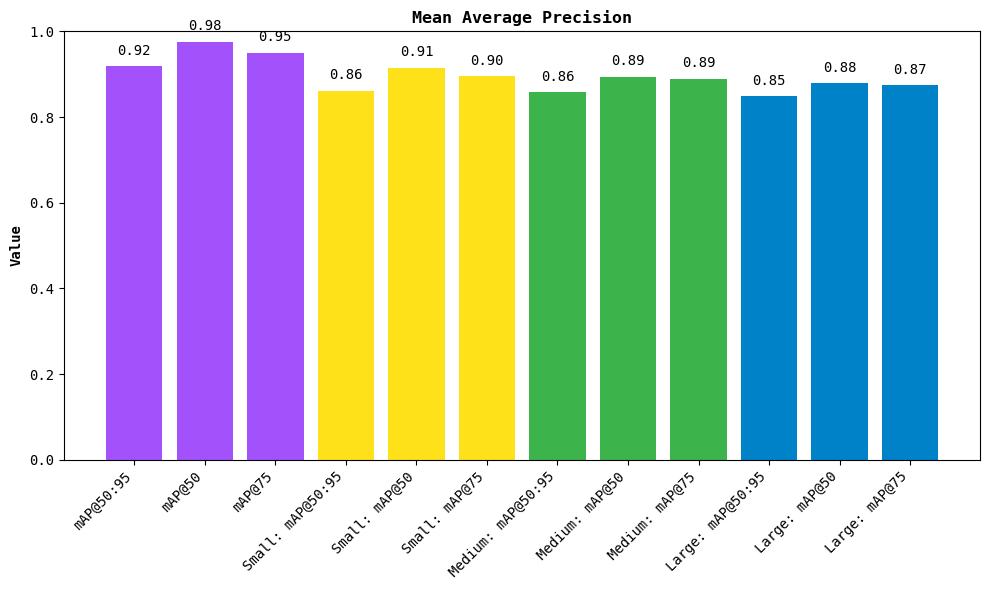

In [23]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()

map_result.plot()